# 02 - Predicting Breast Cancer

The goal of this mini project is to build a classification model that predicts occurrences of breast cancer, classifying tumors as benign or malignant. We use data collected from the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic) for this task.

The data set includes 29 features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe a series of characteristics of the cell nuclei present in the image - such as radius, area, perimeter, texture, smoothness, and others. In total, the data set contains information about 569 subjects.

Different learning algorithms are going to be used to train the models. And, as this is a binary classification problem, results are going to be evaluated in terms of each classifier's sensibility, specificity and the area under the Receiver Operating Characteristic (ROC) curve.

In [1]:
# Load all required libraries.
suppressMessages(library(caret))
suppressMessages(library(MASS))
suppressMessages(library(ggplot2))
suppressMessages(library(corrplot))
suppressMessages(library(pROC))

## 1 Data load

In [2]:
# Data is in CSV format.
df1 <- read.csv('bc_data.csv')

In [3]:
str(df1)

'data.frame':	569 obs. of  32 variables:
 $ id               : int  87139402 8910251 905520 868871 9012568 906539 925291 87880 862989 89827 ...
 $ diagnosis        : Factor w/ 2 levels "B","M": 1 1 1 1 1 1 1 2 1 1 ...
 $ radius_mean      : num  12.3 10.6 11 11.3 15.2 ...
 $ texture_mean     : num  12.4 18.9 16.8 13.4 13.2 ...
 $ perimeter_mean   : num  78.8 69.3 70.9 73 97.7 ...
 $ area_mean        : num  464 346 373 385 712 ...
 $ smoothness_mean  : num  0.1028 0.0969 0.1077 0.1164 0.0796 ...
 $ compactness_mean : num  0.0698 0.1147 0.078 0.1136 0.0693 ...
 $ concavity_mean   : num  0.0399 0.0639 0.0305 0.0464 0.0339 ...
 $ points_mean      : num  0.037 0.0264 0.0248 0.048 0.0266 ...
 $ symmetry_mean    : num  0.196 0.192 0.171 0.177 0.172 ...
 $ dimension_mean   : num  0.0595 0.0649 0.0634 0.0607 0.0554 ...
 $ radius_se        : num  0.236 0.451 0.197 0.338 0.178 ...
 $ texture_se       : num  0.666 1.197 1.387 1.343 0.412 ...
 $ perimeter_se     : num  1.67 3.43 1.34 1.85 1.34 ...
 

In [4]:
tail(df1)

id        diagnosis radius_mean texture_mean perimeter_mean area_mean
564    894855 B         12.86       13.32         82.82          504.8   
565 911320502 B         13.17       18.22         84.28          537.3   
566    898677 B         10.26       14.71         66.20          321.6   
567    873885 M         15.28       22.41         98.92          710.6   
568    911201 B         14.53       13.98         93.86          644.2   
569   9012795 M         21.37       15.10        141.30         1386.0   
    smoothness_mean compactness_mean concavity_mean points_mean ⋯ radius_worst
564 0.11340         0.08834          0.03800        0.03400     ⋯ 14.04       
565 0.07466         0.05994          0.04859        0.02870     ⋯ 14.90       
566 0.09882         0.09159          0.03581        0.02037     ⋯ 10.88       
567 0.09057         0.10520          0.05375        0.03263     ⋯ 17.80       
568 0.10990         0.09242          0.06895        0.06495     ⋯ 15.80       
569 0.10010         0.15150          0.19320        0.12550     ⋯ 22.69       
    texture_worst perimeter_worst area_worst smoothness_worst compactness_worst
564 21.08          92.80           599.5     0.1547           0.2231           
565 23.89          95.10           687.6     0.1282           0.1965           
566 19.48          70.89           357.1     0.1360           0.1636           
567 28.03         113.80           973.1     0.1301           0.3299           
568 16.93         103.10           749.9     0.1347           0.1478           
569 21.84         152.10          1535.0     0.1192           0.2840           
    concavity_worst points_worst symmetry_worst dimension_worst
564 0.17910         0.11550      0.2382         0.08553        
565 0.18760         0.10450      0.2235         0.06925        
566 0.07162         0.04074      0.2434         0.08488        
567 0.36300         0.12260      0.3175         0.09772        
568 0.13730         0.10690      0.2606         0.07810        
569 0.40240         0.19660      0.2730         0.08666

In [5]:
# Count missing values.
sapply(df1, function(x) {
    sum(is.na(x))
})

id         diagnosis       radius_mean      texture_mean 
                0                 0                 0                 0 
   perimeter_mean         area_mean   smoothness_mean  compactness_mean 
                0                 0                 0                 0 
   concavity_mean       points_mean     symmetry_mean    dimension_mean 
                0                 0                 0                 0 
        radius_se        texture_se      perimeter_se           area_se 
                0                 0                 0                 0 
    smoothness_se    compactness_se      concavity_se         points_se 
                0                 0                 0                 0 
      symmetry_se      dimension_se      radius_worst     texture_worst 
                0                 0                 0                 0 
  perimeter_worst        area_worst  smoothness_worst compactness_worst 
                0                 0                 0                 0 
  concavity_worst      points_worst    symmetry_worst   dimension_worst 
                0                 0                 0                 0

Except for the target variable (`diagnosis`), all input features consist of real numbers. Fortunately, there are no missing values.

The two possible categories for `diagnosis` are `B` (benign) and `M` (malignant).

In [6]:
# Split data into training and test data sets.
train.idx <- createDataPartition(df1$diagnosis, p = 0.7, list = FALSE)
df1.train <- df1[train.idx, ]
df1.test <- df1[-train.idx, ]

In [7]:
# Class distribution in the training set.
table(df1.train$diagnosis) / length(df1.train$diagnosis)


        B         M 
0.6265664 0.3734336 

In [8]:
# Class distribution in the test set.
table(df1.test$diagnosis) / length((df1.test$diagnosis))


        B         M 
0.6294118 0.3705882 

The data set was randomly partitioned so that only 70% of its observations will be used to train the model. The remaining 30% will be kept for tests and evaluation.

## 2 Exploratory data analysis

In [9]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)
#
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                         ncol = cols, nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                            layout.pos.col = matchidx$col))
        }
    }
}

### 2.1 Feature distributions

In [10]:
# Compute the mean, minimum, maximum and quartiles of features.
summary(subset(df1.train, select = -c(id, diagnosis)))

  radius_mean      texture_mean   perimeter_mean     area_mean     
 Min.   : 6.981   Min.   : 9.71   Min.   : 43.79   Min.   : 143.5  
 1st Qu.:11.630   1st Qu.:16.33   1st Qu.: 74.60   1st Qu.: 414.9  
 Median :13.300   Median :18.95   Median : 86.10   Median : 551.1  
 Mean   :14.076   Mean   :19.47   Mean   : 91.62   Mean   : 650.0  
 3rd Qu.:15.815   3rd Qu.:22.05   3rd Qu.:104.05   3rd Qu.: 788.0  
 Max.   :27.420   Max.   :39.28   Max.   :186.90   Max.   :2501.0  
 smoothness_mean   compactness_mean  concavity_mean     points_mean     
 Min.   :0.05263   Min.   :0.01938   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.08564   1st Qu.:0.06352   1st Qu.:0.02872   1st Qu.:0.01965  
 Median :0.09488   Median :0.09242   Median :0.06476   Median :0.03384  
 Mean   :0.09597   Mean   :0.10381   Mean   :0.08837   Mean   :0.04852  
 3rd Qu.:0.10455   3rd Qu.:0.13045   3rd Qu.:0.12665   3rd Qu.:0.07370  
 Max.   :0.16340   Max.   :0.34540   Max.   :0.42680   Max.   :0.20120  
 symmetry_mea

Different features have different ranges of values, and some feature distributions seem to be significantly right skewed (most data is less than the mean).

In [11]:
# Set the default figure size.
options(repr.plot.width = 6, repr.plot.height = 3)

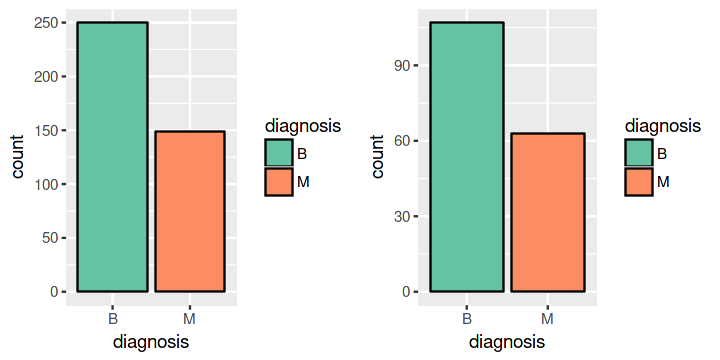

In [12]:
# Plot the frequencies of benign and malignant cases.
multiplot(ggplot(df1.train, aes(x = diagnosis, fill = diagnosis)) +
              geom_bar(colour = 'black') +
              scale_fill_brewer(palette = 'Set2'),
          ggplot(df1.test, aes(x = diagnosis, fill = diagnosis)) +
              geom_bar(colour = 'black') +
              scale_fill_brewer(palette = 'Set2'),
          cols = 2)

In both partitions, there are about 1.67 times more benign cases (`B`) than malignant ones (`M`).

In [13]:
options(repr.plot.width = 6, repr.plot.height = 1.5)

In [14]:
feature.names <- colnames(subset(df1.train, select = -c(id, diagnosis)))

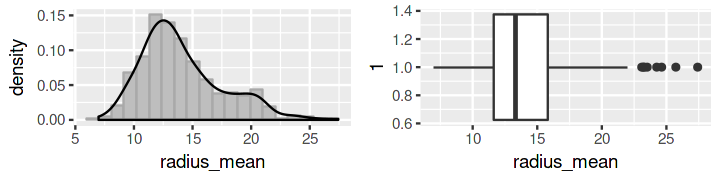

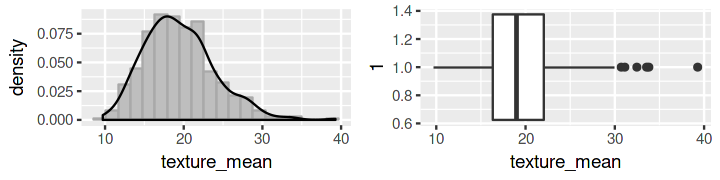

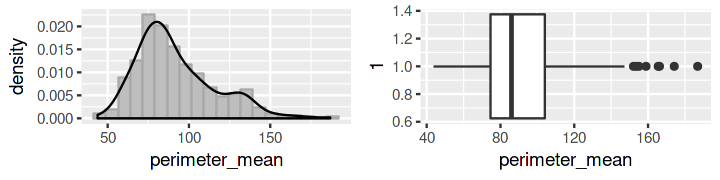

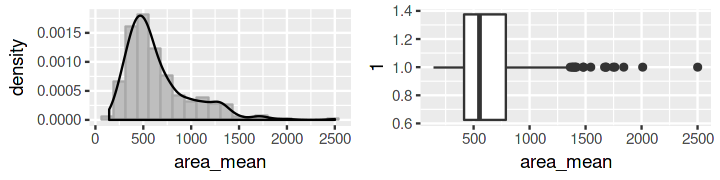

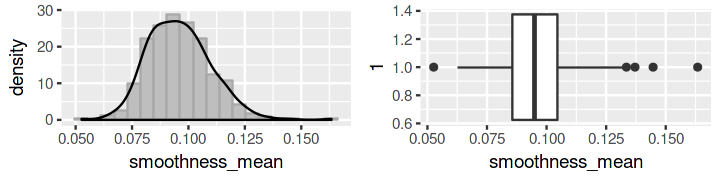

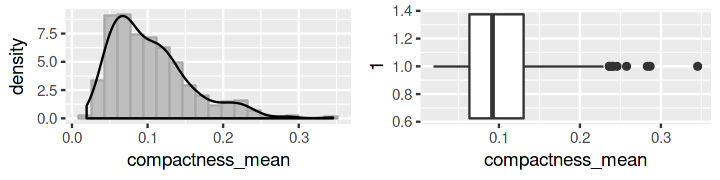

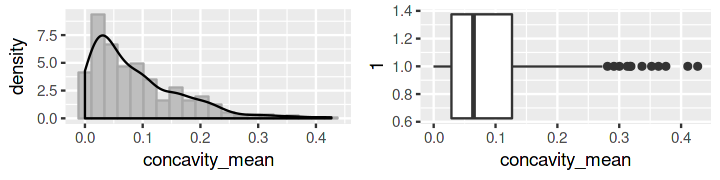

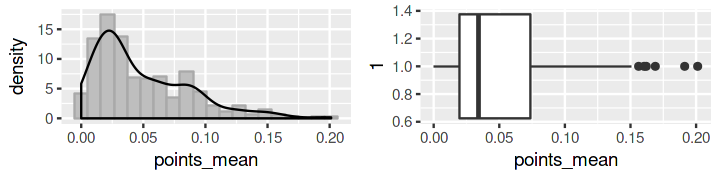

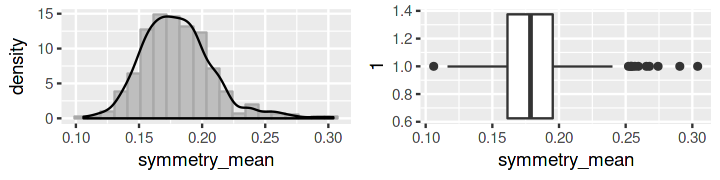

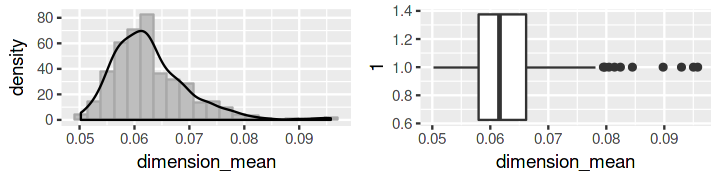

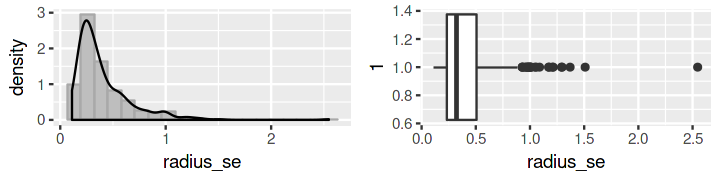

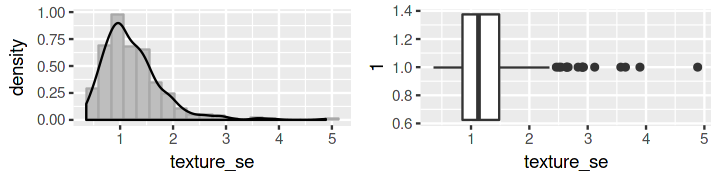

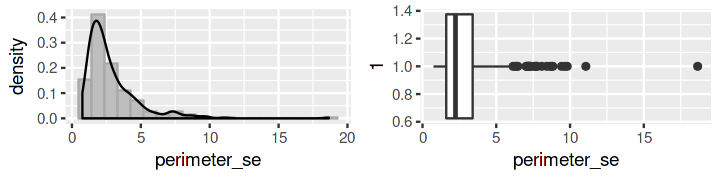

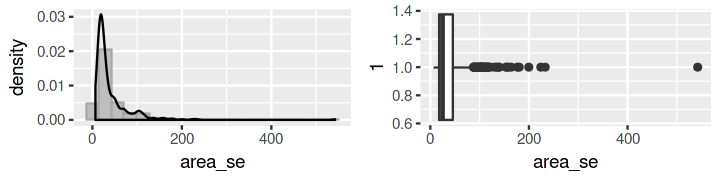

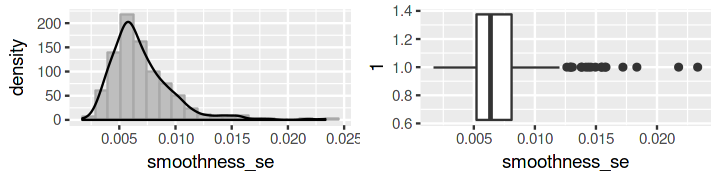

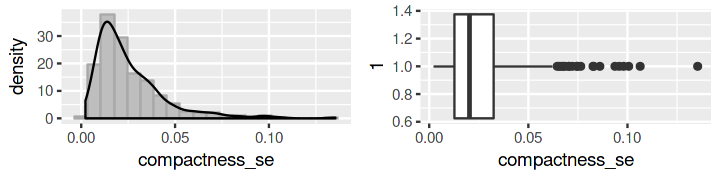

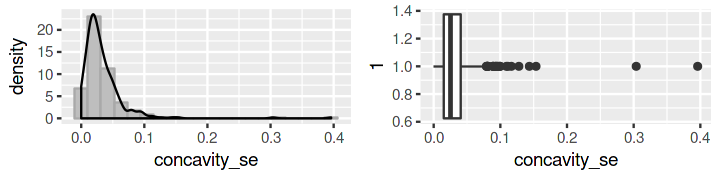

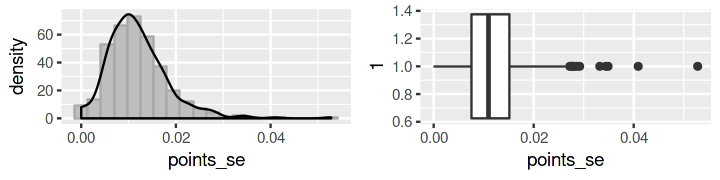

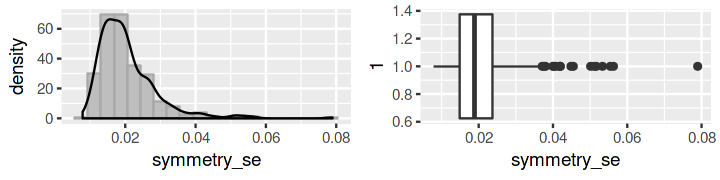

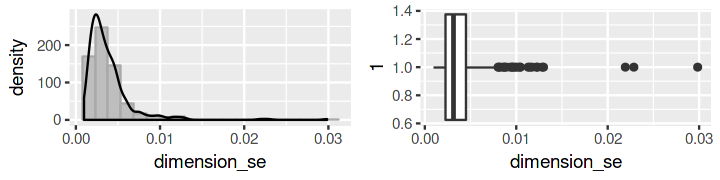

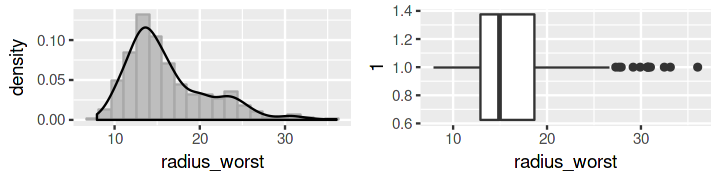

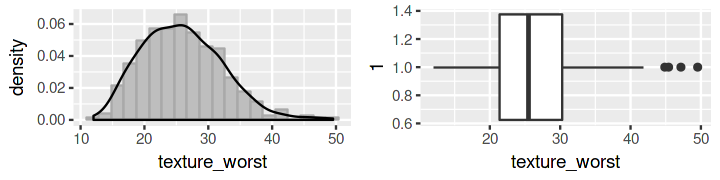

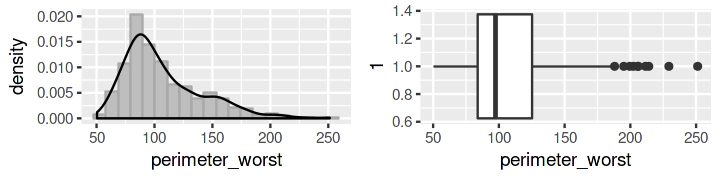

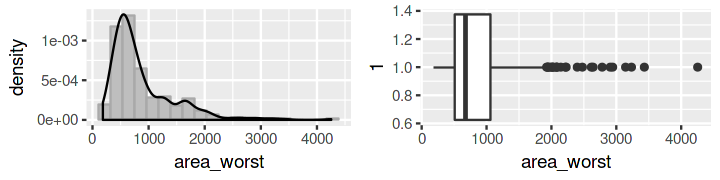

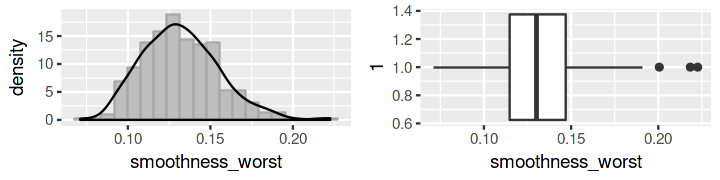

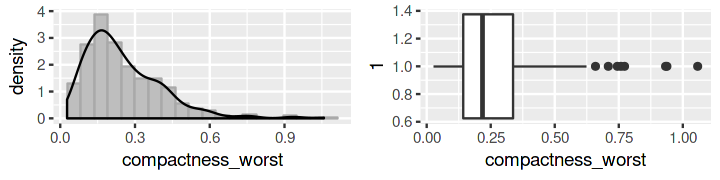

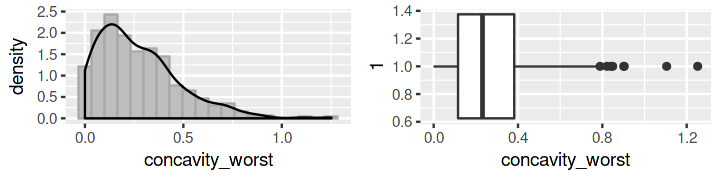

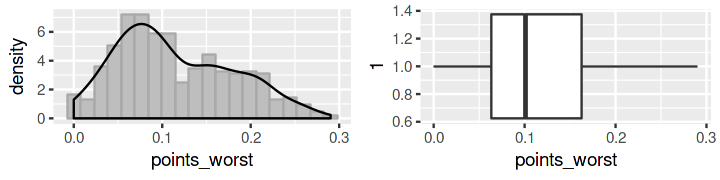

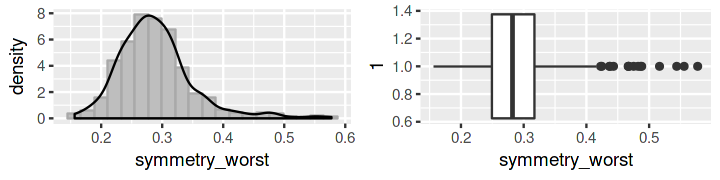

$radius_mean
NULL

$texture_mean
NULL

$perimeter_mean
NULL

$area_mean
NULL

$smoothness_mean
NULL

$compactness_mean
NULL

$concavity_mean
NULL

$points_mean
NULL

$symmetry_mean
NULL

$dimension_mean
NULL

$radius_se
NULL

$texture_se
NULL

$perimeter_se
NULL

$area_se
NULL

$smoothness_se
NULL

$compactness_se
NULL

$concavity_se
NULL

$points_se
NULL

$symmetry_se
NULL

$dimension_se
NULL

$radius_worst
NULL

$texture_worst
NULL

$perimeter_worst
NULL

$area_worst
NULL

$smoothness_worst
NULL

$compactness_worst
NULL

$concavity_worst
NULL

$points_worst
NULL

$symmetry_worst
NULL

$dimension_worst
NULL


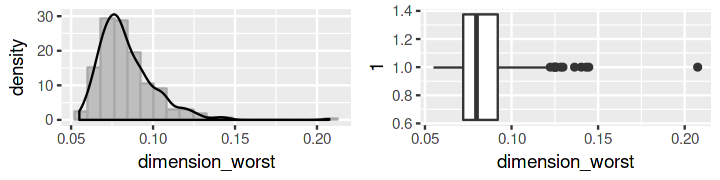

In [15]:
# Plot the distributions of all input features.
sapply(feature.names, function (x) {
    multiplot(ggplot(df1.train, aes_string(x = x, y = '..density..')) +
                  geom_histogram(bins = 20, fill = 'grey', colour = 'darkgrey') +
                  geom_density(),
              ggplot(df1.train, aes_string(x = '1', y = x)) +
                  geom_boxplot() +
                  coord_flip(),
              cols = 2)
})

Roughly speaking, the distribution of each feature can be approximated by a somewhat skewed, bell-shaped like curve. So it seems a good idea to apply some feature transformations to make their distributions look more Gaussian like (since some learning algorithms assume that the inputs are normally distributed) and also to put all features in the same range.

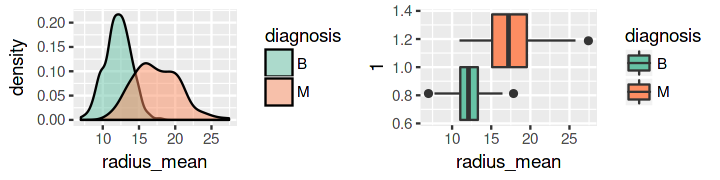

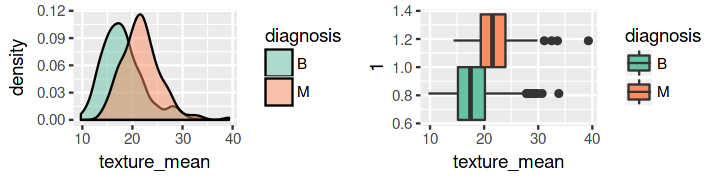

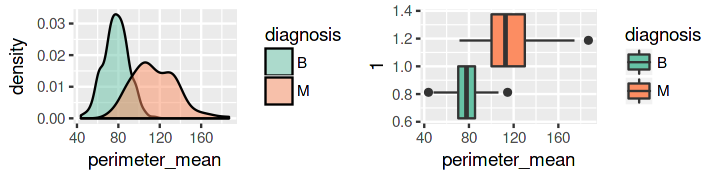

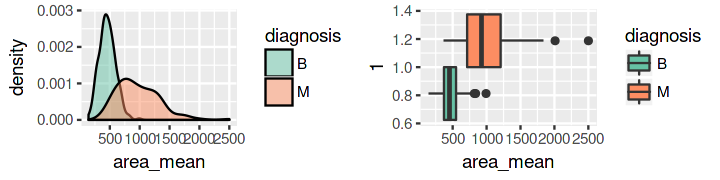

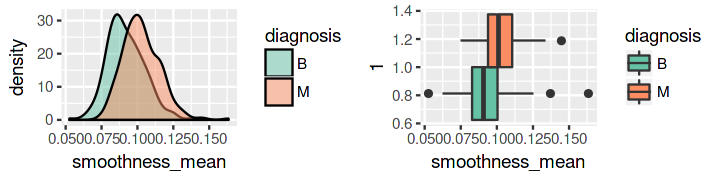

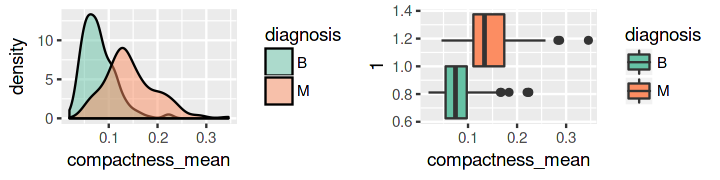

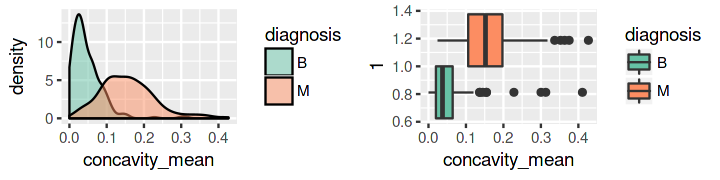

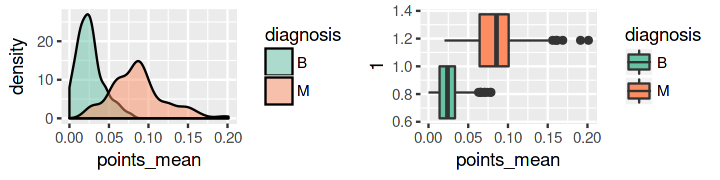

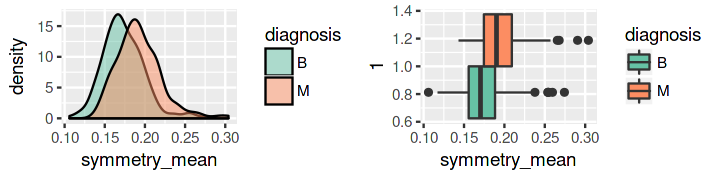

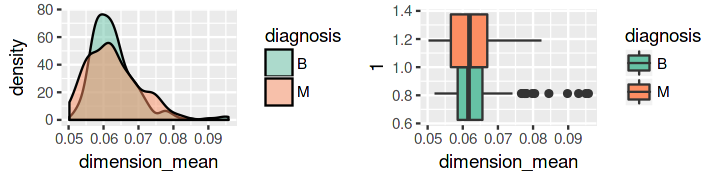

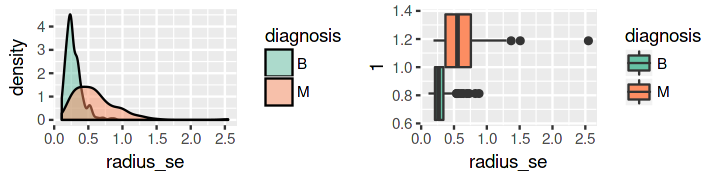

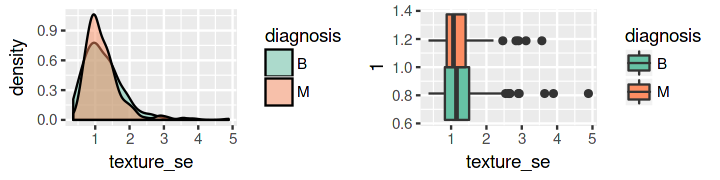

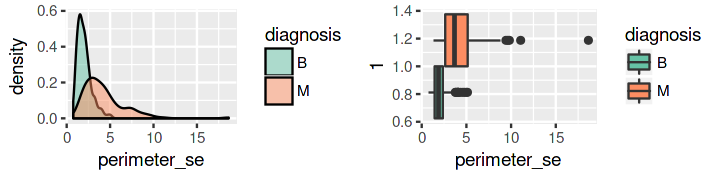

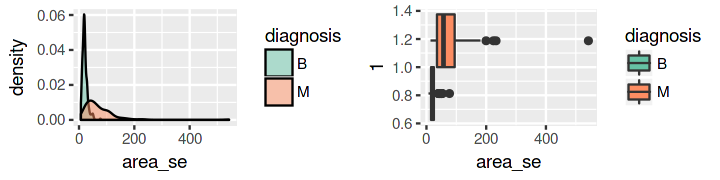

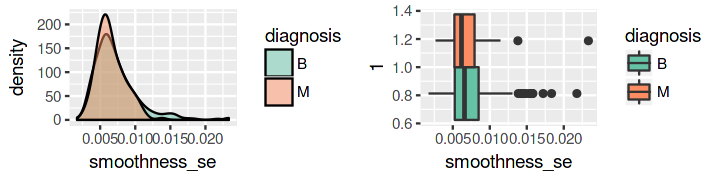

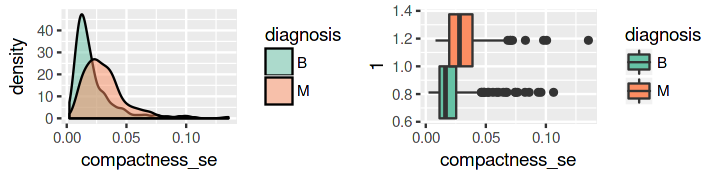

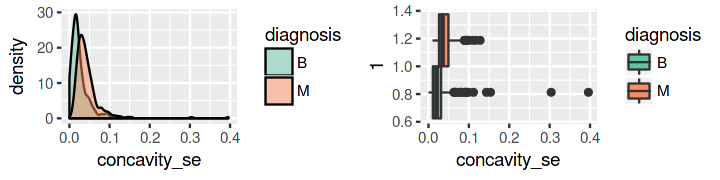

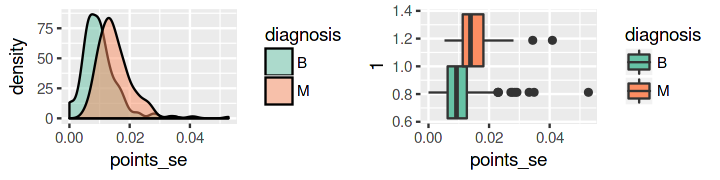

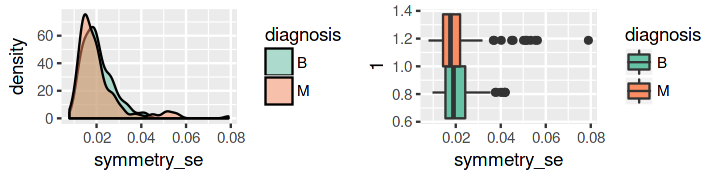

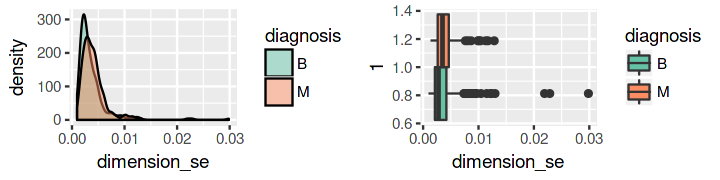

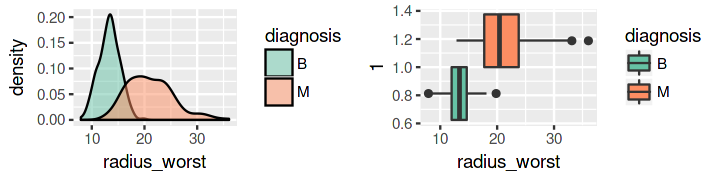

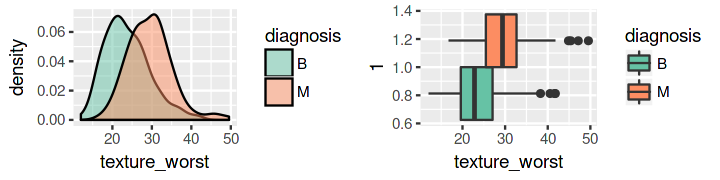

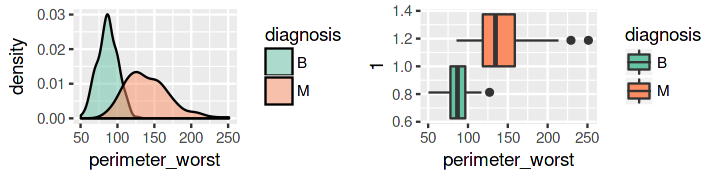

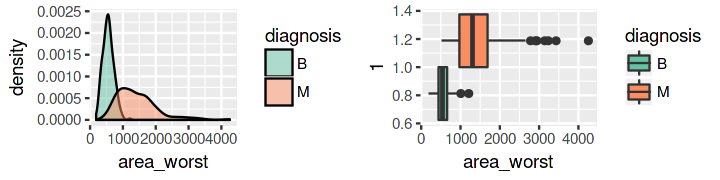

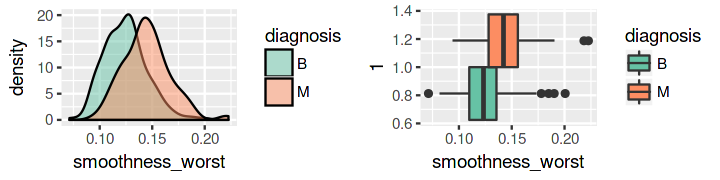

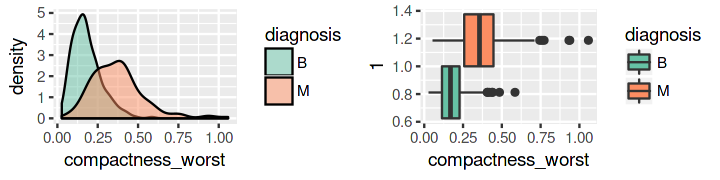

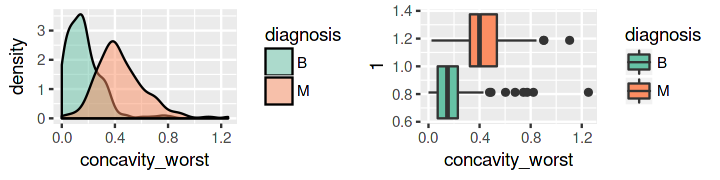

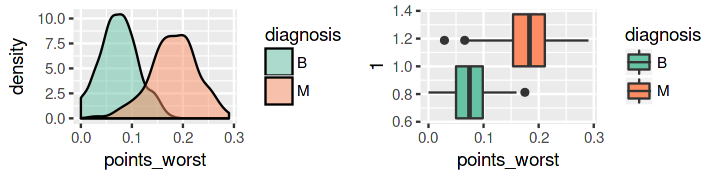

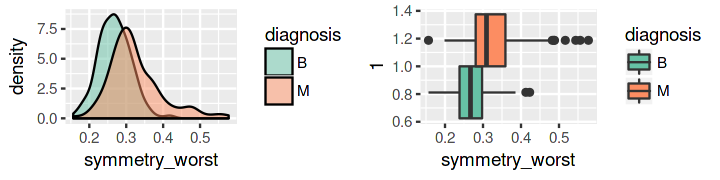

$radius_mean
NULL

$texture_mean
NULL

$perimeter_mean
NULL

$area_mean
NULL

$smoothness_mean
NULL

$compactness_mean
NULL

$concavity_mean
NULL

$points_mean
NULL

$symmetry_mean
NULL

$dimension_mean
NULL

$radius_se
NULL

$texture_se
NULL

$perimeter_se
NULL

$area_se
NULL

$smoothness_se
NULL

$compactness_se
NULL

$concavity_se
NULL

$points_se
NULL

$symmetry_se
NULL

$dimension_se
NULL

$radius_worst
NULL

$texture_worst
NULL

$perimeter_worst
NULL

$area_worst
NULL

$smoothness_worst
NULL

$compactness_worst
NULL

$concavity_worst
NULL

$points_worst
NULL

$symmetry_worst
NULL

$dimension_worst
NULL


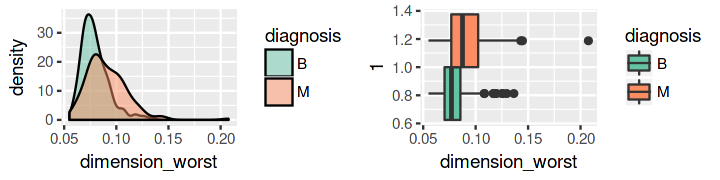

In [16]:
# Plot the distributions of all input features w.r.t. the target variable.
sapply(feature.names, function (x) {
    multiplot(ggplot(df1.train, aes_string(x = x, y = '..density..', fill = 'diagnosis')) +
                  geom_density(alpha = 0.5) +
                  scale_fill_brewer(palette = 'Set2'),
              ggplot(df1.train, aes_string(x = '1', y = x, fill = 'diagnosis')) +
                  geom_boxplot() +
                  coord_flip() +
                  scale_fill_brewer(palette = 'Set2'),
              cols = 2)
})

The plots above show the distributions of all features with respect to the diagnosis value. Now it is possible to have a rough idea of which features could be better predictors and which ones probably won't be of much help in discriminating benign from malignant cases. For instance, `points_mean` looks way more useful than `smoothness_se`.

### 2.2 Feature correlations

In [17]:
# Multiple correlation test function.
#
# Computes tests for association/correlation between paired samples
# represented in the rows and columns of a matrix.
#
# Source: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
#
cor.mtest <- function(mat, conf.level = 0.95){
  mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

In [18]:
# Compute the p-values for the correlation tests.
cor.p <- cor.mtest(df1.train[, feature.names])[[1]]

In [19]:
options(repr.plot.width = 8, repr.plot.height = 7)

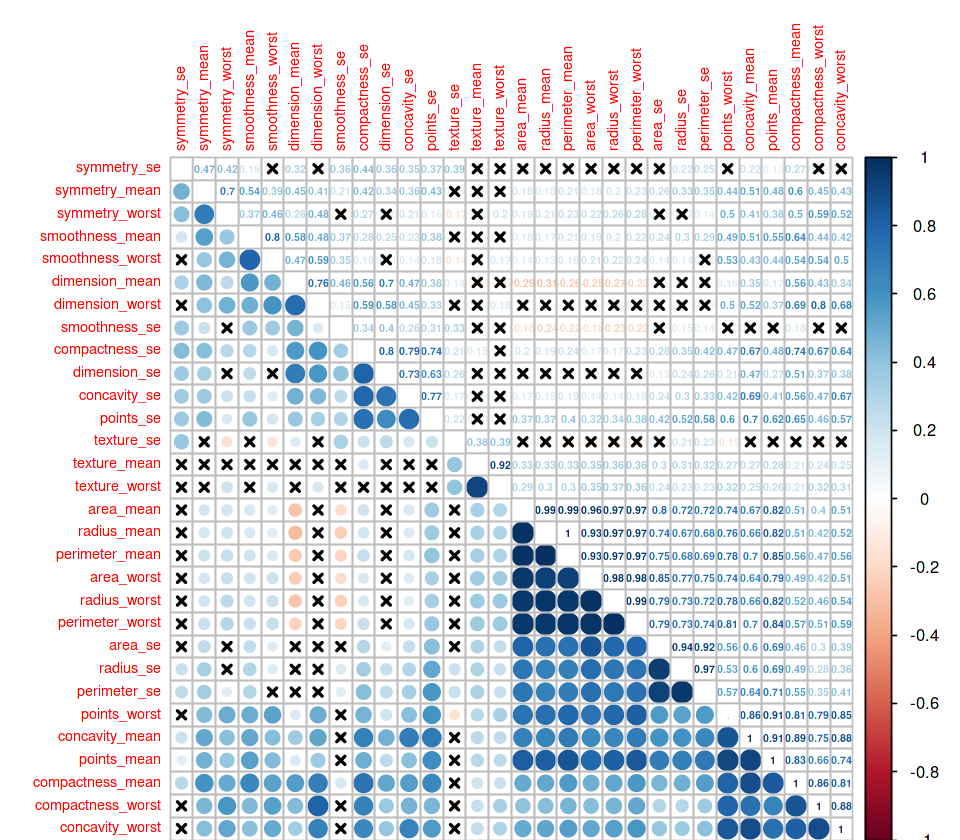

In [20]:
# Plot the pairwise feature correlation map.
corrplot.mixed(cor(df1.train[, feature.names]),
               lower = 'circle',
               upper = 'number',
               order = 'hclust',
               p.mat =  cor.p,
               sig.level = 0.01,
               tl.pos = 'lt',
               tl.cex = 0.7,
               number.cex = 0.5,
               pch.cex = 0.9)

The correlation map above shows that there are many correlated features in this data set. This is not a surprise, since it is clear that characteristics such as area, perimeter and radius (for example) would influence each other.

As multicollinearity can be a source of problems for most predictive models, it should be handled somehow. A good approach is to apply feature extraction techniques to transform the original data into a set of uncorrelated features.

## 3 Data preparation

In [21]:
# log.start function
#
# Find a constant `const` for which log(y+c) is as symmetric
# as possible at the `alpha` and 1-alpha percentiles.
# Returns a list containing the solution and a code:
#   Code=0: Constant is good.
#   Code=1: Data are already symmetric.
#   Code=2: The best solution is not large enough and has been adjusted.
#           In this case, the constant is obtained by extrapolating to the
#           left from the `beta` percentile beyond the minimum value of `y`;
#           the extrapolation is by a (small, positive) amount `gamma`.
#
# Source: http://stats.stackexchange.com/questions/41361/choosing-c-such-that-logx-c-would-remove-skew-from-the-population (whuber's answer)
#
log.start <- function(y, alpha=0.25, beta=1, gamma=0.01) {
    stats <- quantile(y, c(alpha, 1/2, 1-alpha))
    code <- 0
    
    if (diff(diff(stats)==0)) {
        const <- Inf
        code <- 1
    } else {
        const <- (stats[2]^2 - stats[1]*stats[3]) / (stats[1] + stats[3] - 2*stats[2])
        y.min <- min(y)
        
        if (const < -y.min) {
            const <- gamma * quantile(y, beta) - (1+gamma) * y.min
            code <- 2
        }
    }
    list(offset=as.numeric(const), code=code)
}

### 3.1 Data unskewing

In [22]:
df2.train <- df1.train
df2.test <- df1.test

In [23]:
# Get the constants that unskew 95% of the distribution of each feature. 
const <- sapply(df2.train[, feature.names], function (x) {
    log.start(x, alpha = 0.025)$offset
})
const

radius_mean      texture_mean    perimeter_mean         area_mean 
    -4.163973e+00     -2.334556e-01     -3.418621e+01     -9.466093e+01 
  smoothness_mean  compactness_mean    concavity_mean       points_mean 
    -1.394842e-02     -9.729917e-04      2.403612e-02      1.091592e-02 
    symmetry_mean    dimension_mean         radius_se        texture_se 
    -7.298071e-02     -4.276440e-02     -8.311607e-02      3.156161e-02 
     perimeter_se           area_se     smoothness_se    compactness_se 
    -7.004677e-01     -1.448020e+00     -1.444821e-03     -1.268476e-03 
     concavity_se         points_se       symmetry_se      dimension_se 
     1.260640e-02      1.003350e-02     -6.701303e-03     -8.069195e-04 
     radius_worst     texture_worst   perimeter_worst        area_worst 
    -6.474630e+00      1.185195e+01     -4.171352e+01     -1.840681e+02 
 smoothness_worst compactness_worst   concavity_worst      points_worst 
    -1.862560e-03      3.845559e-02      1.744641e-01      1.402800e-01 
   symmetry_worst   dimension_worst 
    -1.013385e-01     -4.622229e-02

In [24]:
# Apply logarithms to unskew the feature distributions.
df2.train[, feature.names] <- data.frame(sapply(feature.names, function (x) {
    log(df1.train[, x] + const[x])
}))

df2.test[, feature.names] <- data.frame(sapply(feature.names, function (x) {
    y <- df1.test[, x] + const[x]
    log(ifelse(y > 0, y, 1e-9))
}))

In [25]:
options(repr.plot.width = 6, repr.plot.height = 1.5)

Since most feature distributions were right skewed, we tried to unskew them by applying the logarithm function (which is monotonic increasing). For each feature `x`, the `c` constant that makes the distribution of `log(x + c)` as symmetric as possible was automatically estimated.

### 3.2 Data scaling

In [26]:
# Get the mean and std of each input feature.
mu <- sapply(df2.train[, feature.names], function(x) {
    mean(x)
})
sigma <- sapply(df2.train[, feature.names], function(x) {
    sd(x)
})

In [27]:
df3.train <- df2.train
df3.test <- df2.test

In [28]:
# Put all features in the same scale, with zero mean and unit variance.
df3.train[, feature.names] <- data.frame(sapply(feature.names, function (x) {
    (df3.train[, x] - mu[x]) / sigma[x]
}))

df3.test[, feature.names] <- data.frame(sapply(feature.names, function (x) {
    (df3.test[, x] - mu[x]) / sigma[x]
}))

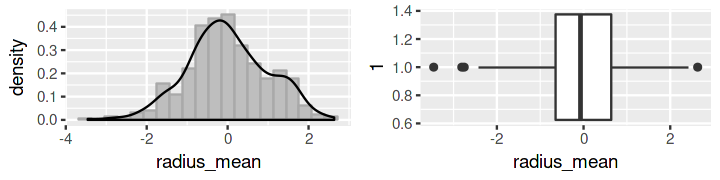

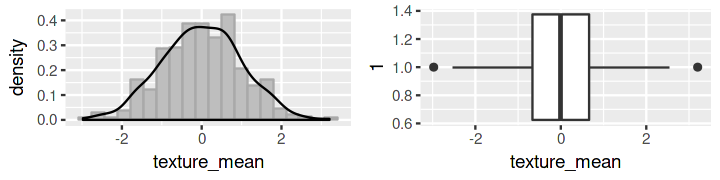

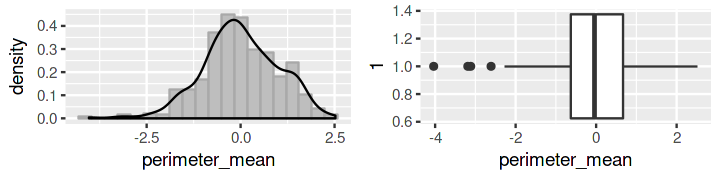

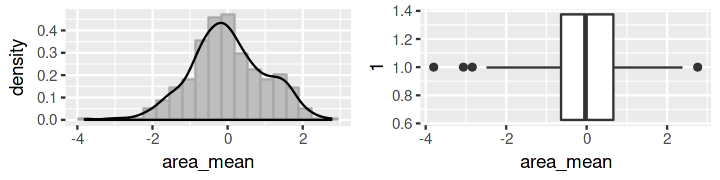

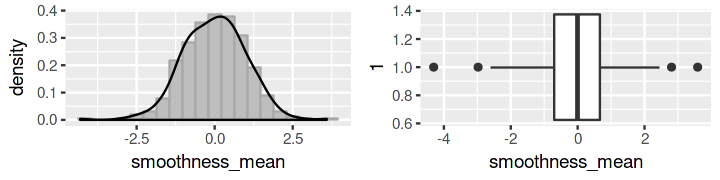

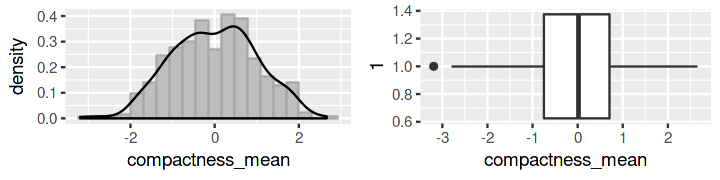

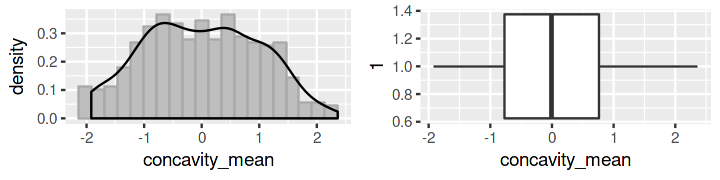

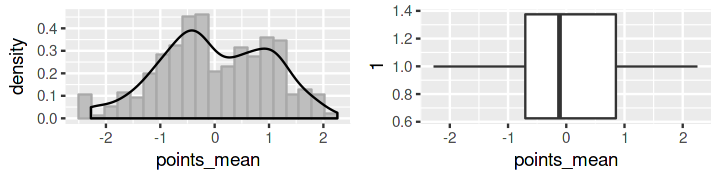

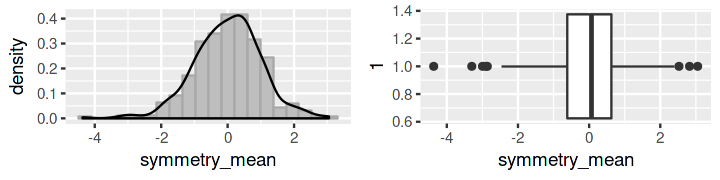

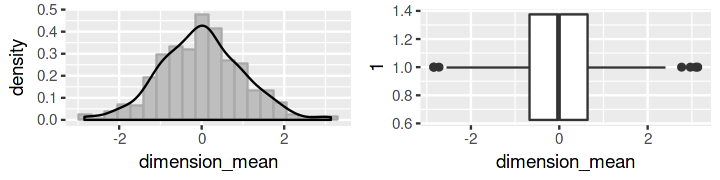

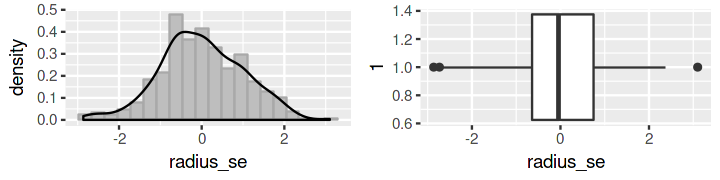

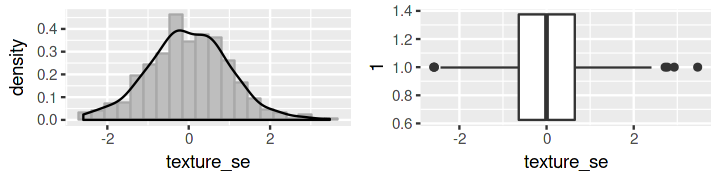

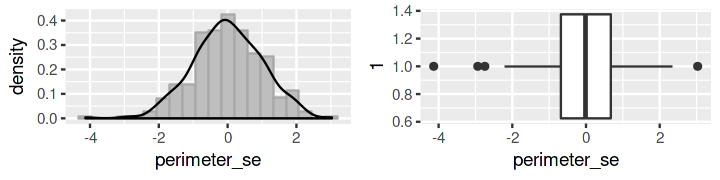

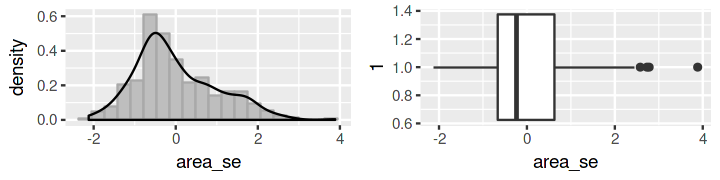

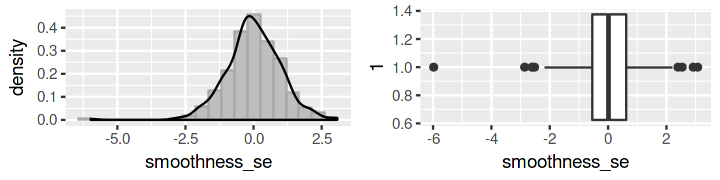

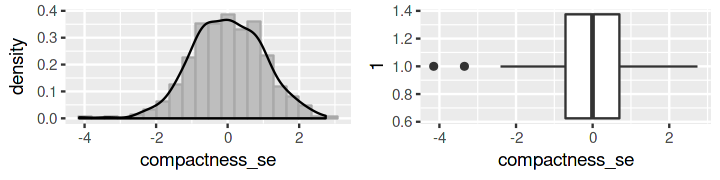

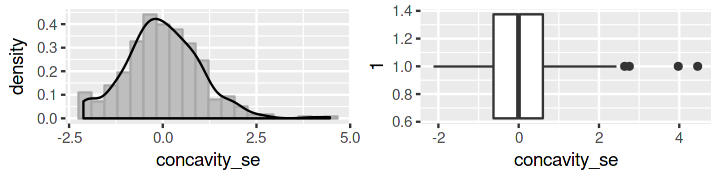

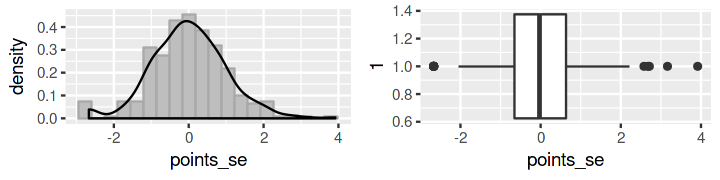

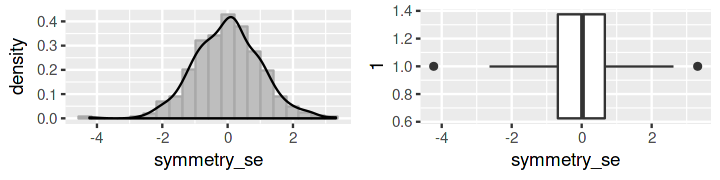

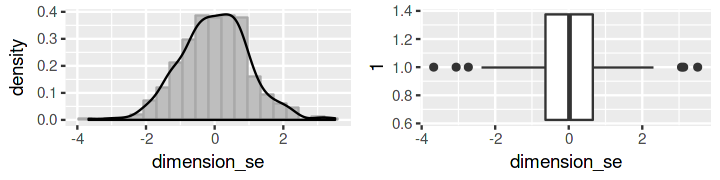

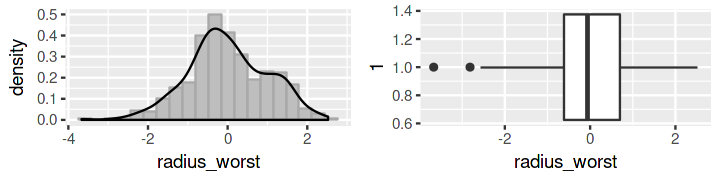

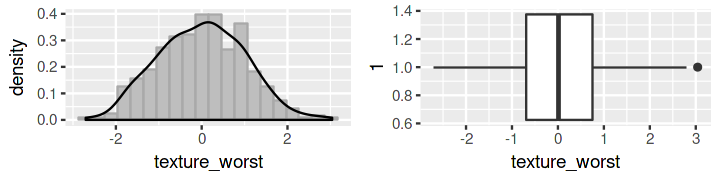

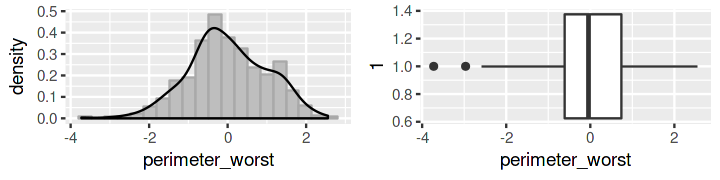

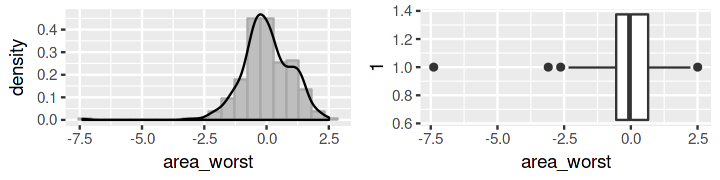

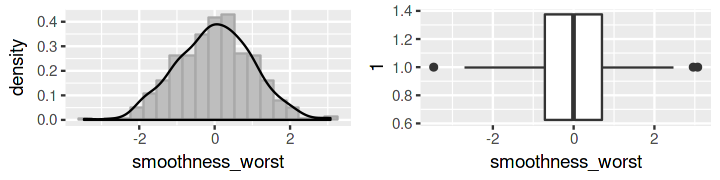

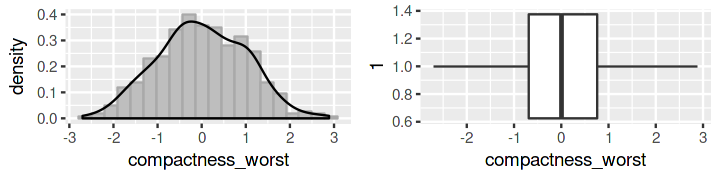

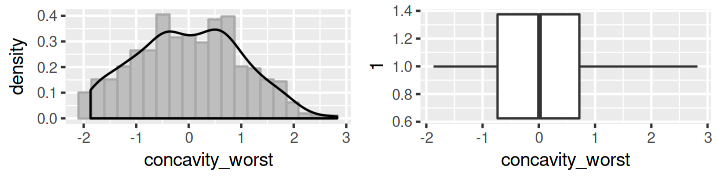

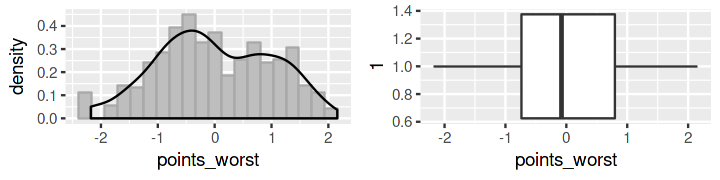

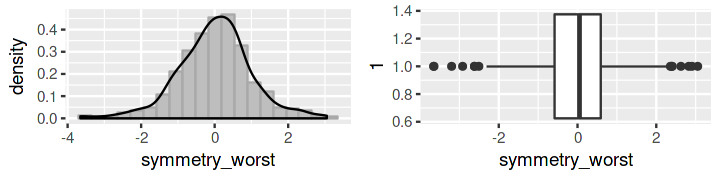

$radius_mean
NULL

$texture_mean
NULL

$perimeter_mean
NULL

$area_mean
NULL

$smoothness_mean
NULL

$compactness_mean
NULL

$concavity_mean
NULL

$points_mean
NULL

$symmetry_mean
NULL

$dimension_mean
NULL

$radius_se
NULL

$texture_se
NULL

$perimeter_se
NULL

$area_se
NULL

$smoothness_se
NULL

$compactness_se
NULL

$concavity_se
NULL

$points_se
NULL

$symmetry_se
NULL

$dimension_se
NULL

$radius_worst
NULL

$texture_worst
NULL

$perimeter_worst
NULL

$area_worst
NULL

$smoothness_worst
NULL

$compactness_worst
NULL

$concavity_worst
NULL

$points_worst
NULL

$symmetry_worst
NULL

$dimension_worst
NULL


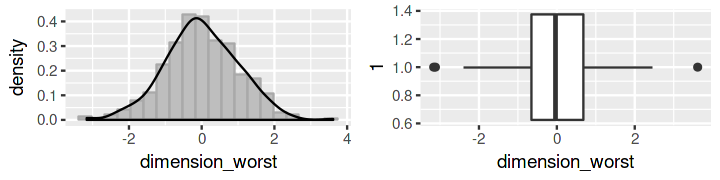

In [29]:
# Plot the new distributions of all input features.
sapply(feature.names, function (x) {
    multiplot(ggplot(df3.train, aes_string(x = x, y = '..density..')) +
                  geom_histogram(bins = 20, fill = 'grey', colour = 'darkgrey') +
                  geom_density(),
              ggplot(df3.train, aes_string(x = '1', y = x)) +
                  geom_boxplot() +
                  coord_flip(),
              cols = 2)
})

Feature scaling is important to ensure that all features have the same weight for the learning algorithm. A simple computation put all feature distributions to zero mean and unit variance.

The resulting distributions surely look more symmetric now, but they're still not perfect mostly because of outliers.

### 3.3 Outlier removal

In [30]:
df4.train <- df3.train
df4.test <- df3.test

In [31]:
# Replace all values below -3 or above 3 by NA.
df4.train[, feature.names] <- sapply(feature.names, function (x) {
    y <- df4.train[, x]
    df4.train[, x] <- ifelse(abs(y) > 3, NA, y)
})

In [32]:
# Remove all observations that contain NA.
df4.train <- na.omit(df4.train)

In [33]:
# Count how many observations  were removed.
nrow(df3.train) - nrow(df4.train)

[1] 28

In [34]:
# New class distribution in the training set.
table(df4.train$diagnosis) / length((df4.train$diagnosis))


        B         M 
0.6280323 0.3719677 

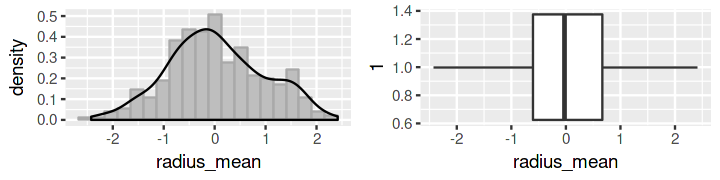

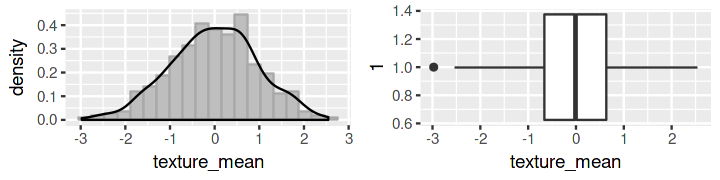

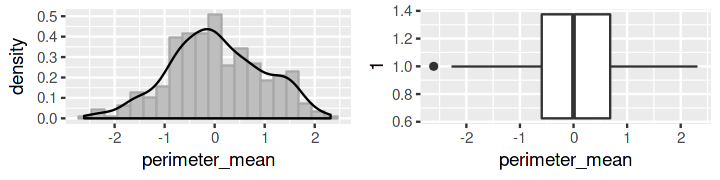

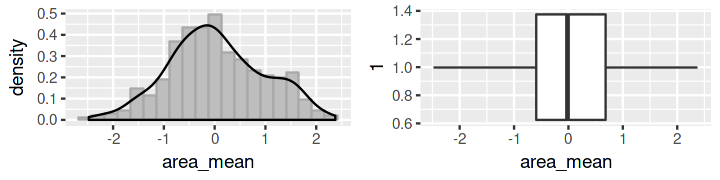

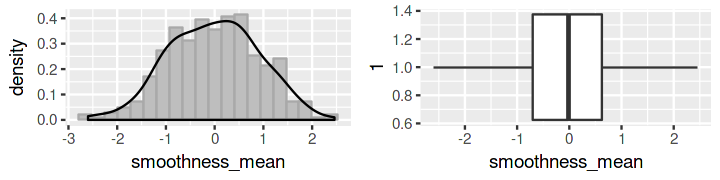

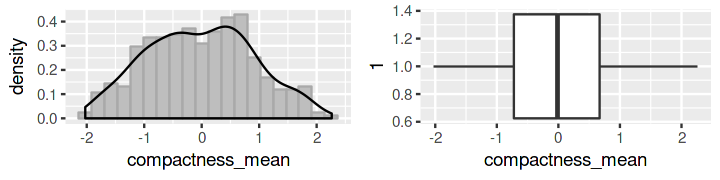

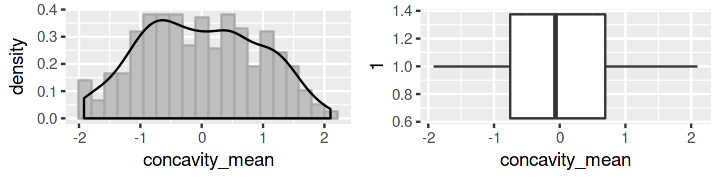

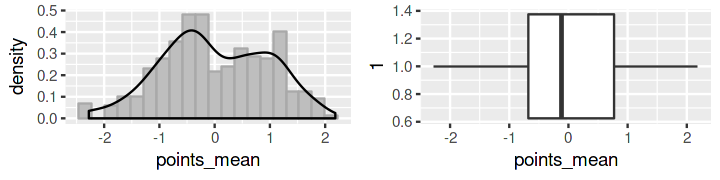

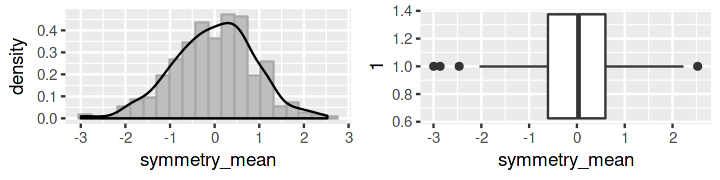

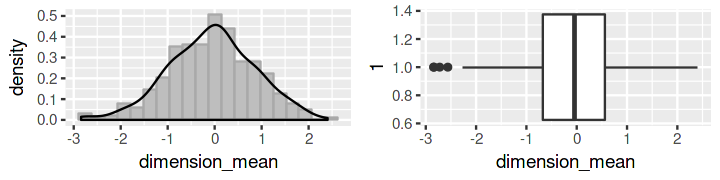

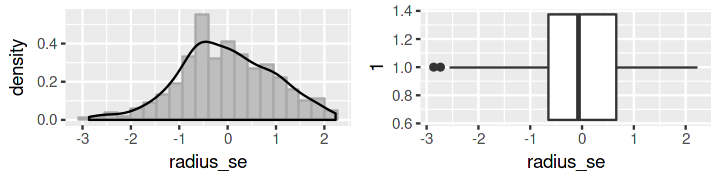

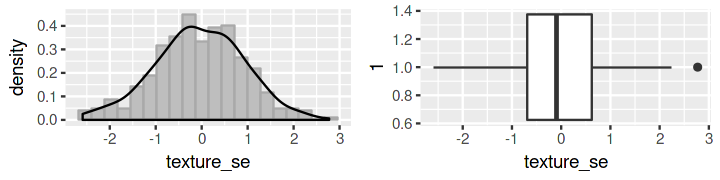

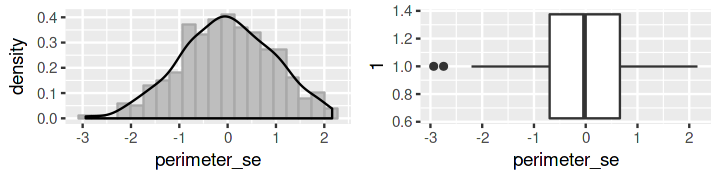

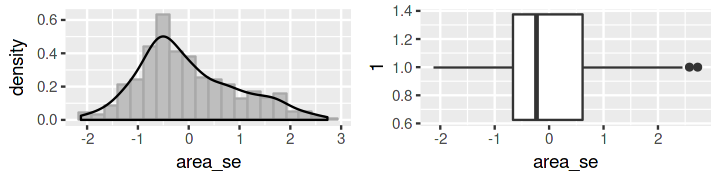

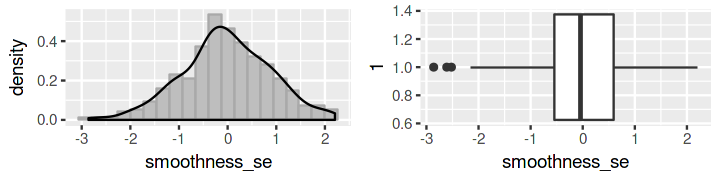

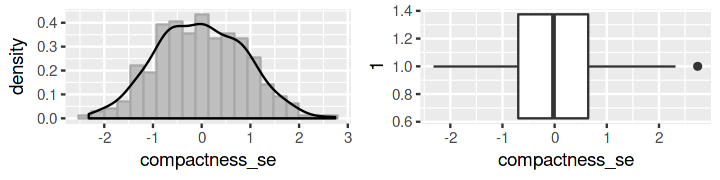

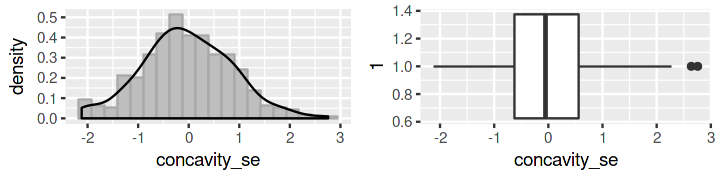

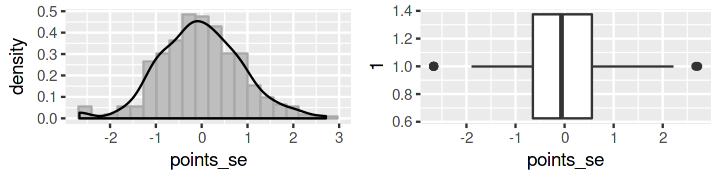

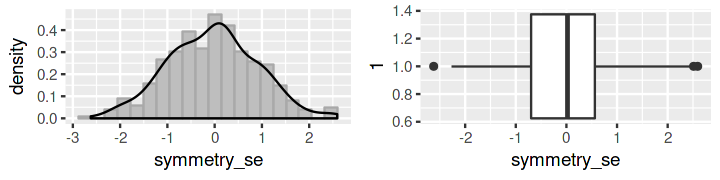

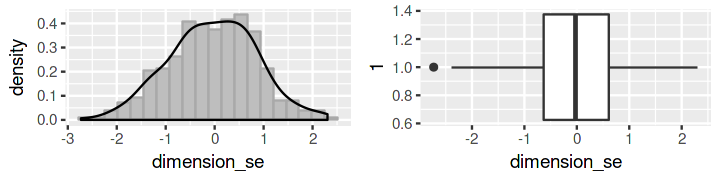

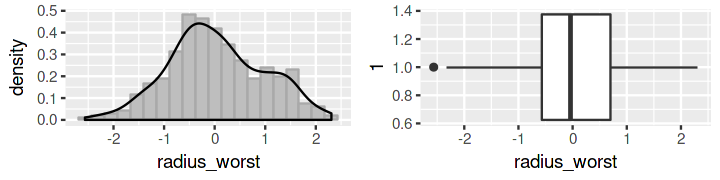

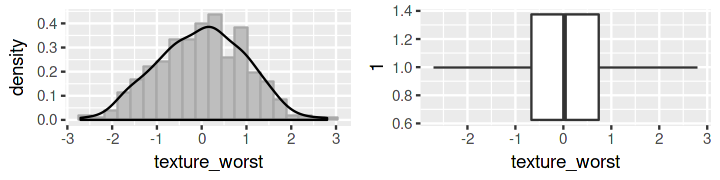

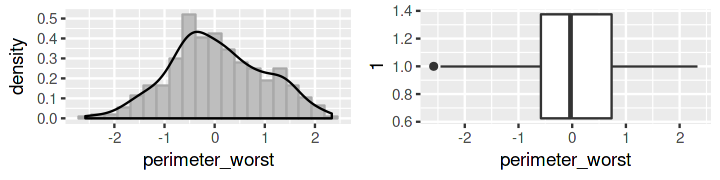

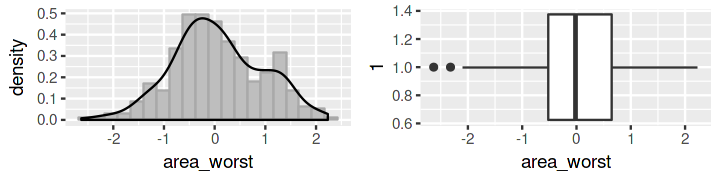

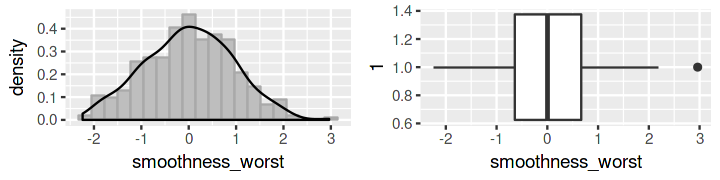

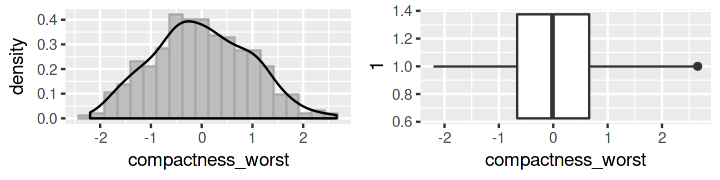

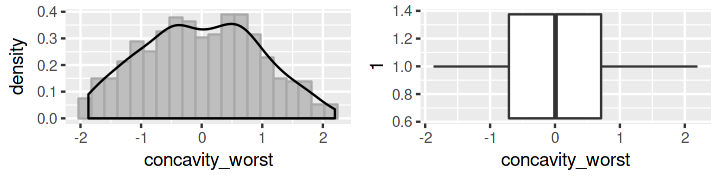

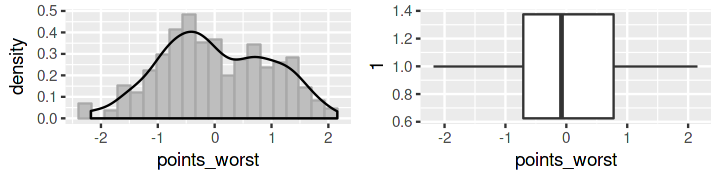

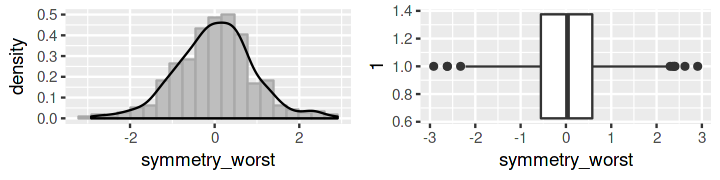

$radius_mean
NULL

$texture_mean
NULL

$perimeter_mean
NULL

$area_mean
NULL

$smoothness_mean
NULL

$compactness_mean
NULL

$concavity_mean
NULL

$points_mean
NULL

$symmetry_mean
NULL

$dimension_mean
NULL

$radius_se
NULL

$texture_se
NULL

$perimeter_se
NULL

$area_se
NULL

$smoothness_se
NULL

$compactness_se
NULL

$concavity_se
NULL

$points_se
NULL

$symmetry_se
NULL

$dimension_se
NULL

$radius_worst
NULL

$texture_worst
NULL

$perimeter_worst
NULL

$area_worst
NULL

$smoothness_worst
NULL

$compactness_worst
NULL

$concavity_worst
NULL

$points_worst
NULL

$symmetry_worst
NULL

$dimension_worst
NULL


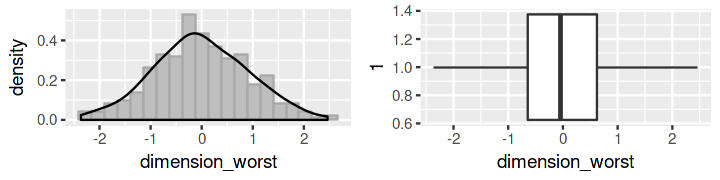

In [35]:
# Plot the new distributions of all input features.
sapply(feature.names, function (x) {
    multiplot(ggplot(df4.train, aes_string(x = x, y = '..density..')) +
                  geom_histogram(bins = 20, fill = 'grey', colour = 'darkgrey') +
                  geom_density(),
              ggplot(df4.train, aes_string(x = '1', y = x)) +
                  geom_boxplot() +
                  coord_flip(),
              cols = 2)
})

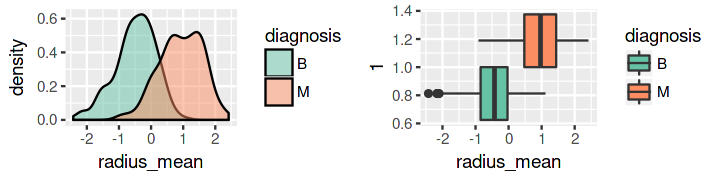

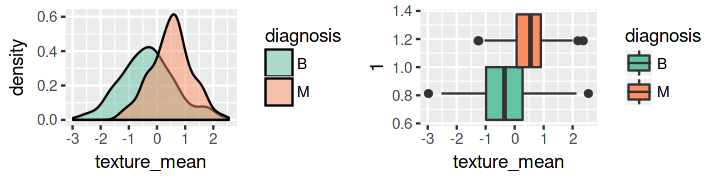

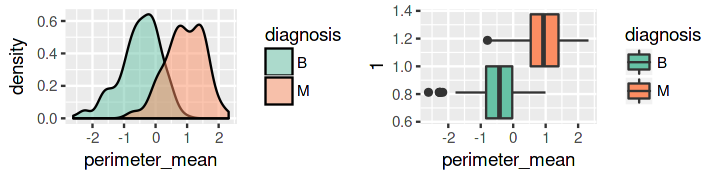

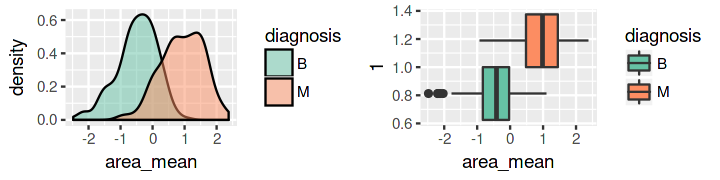

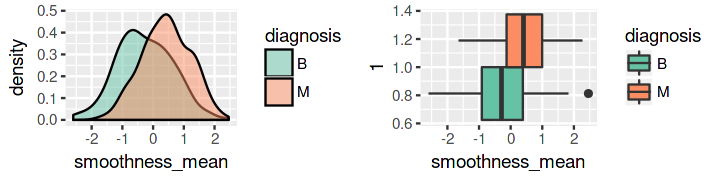

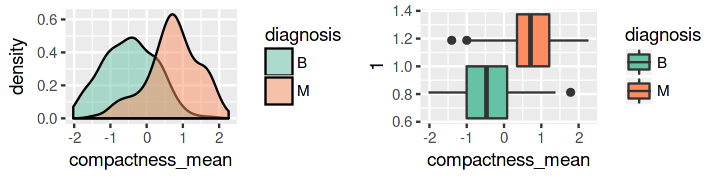

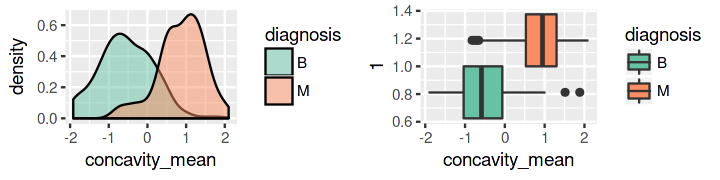

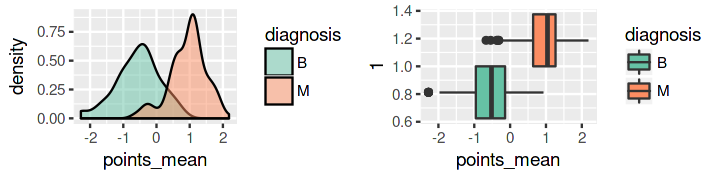

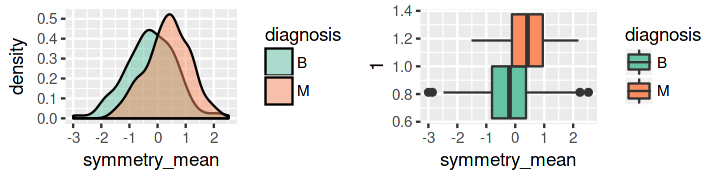

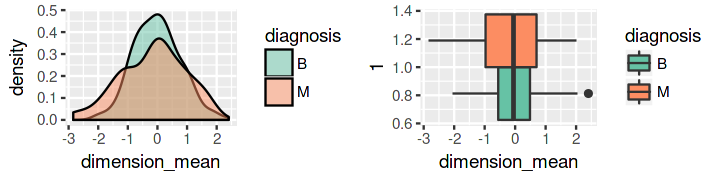

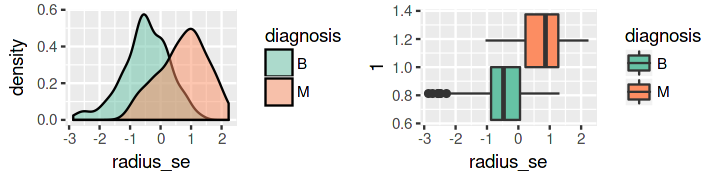

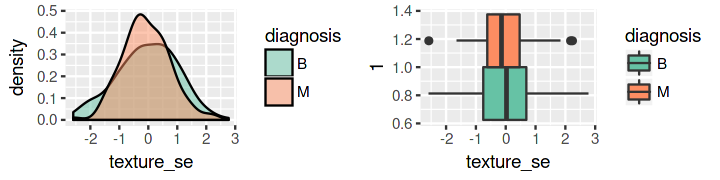

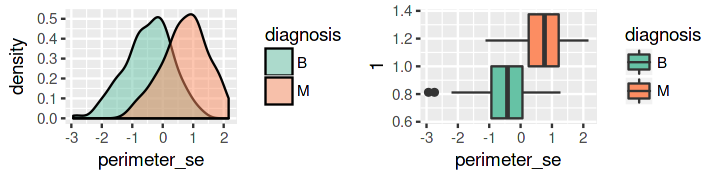

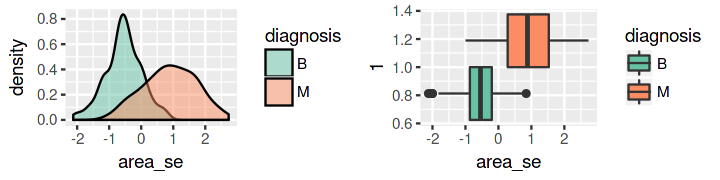

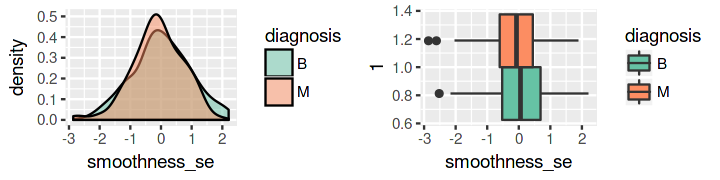

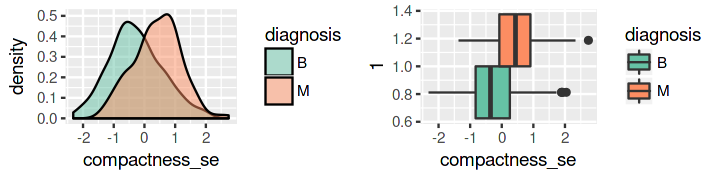

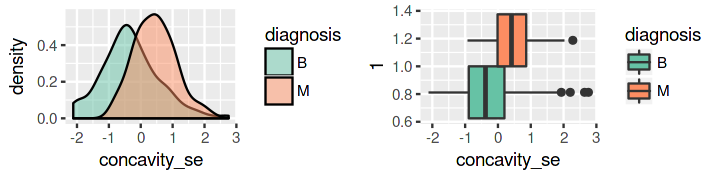

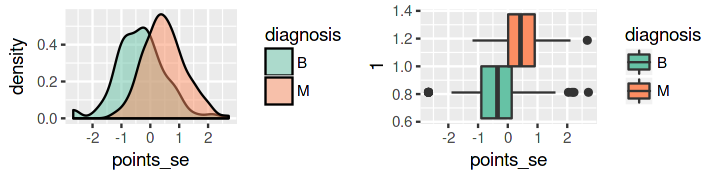

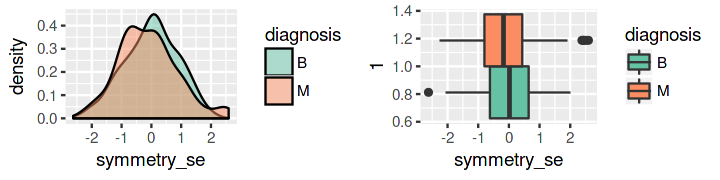

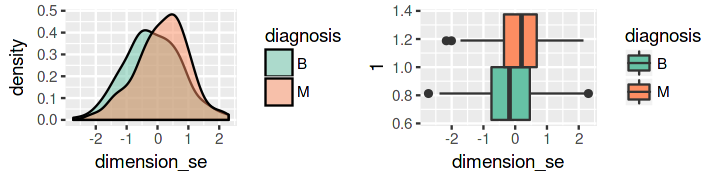

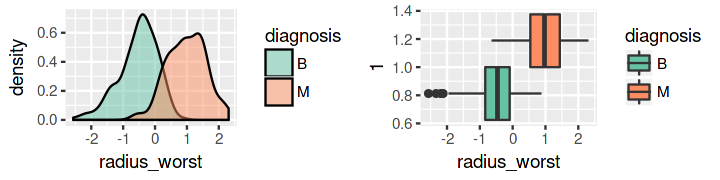

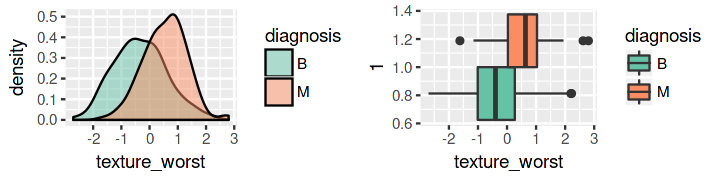

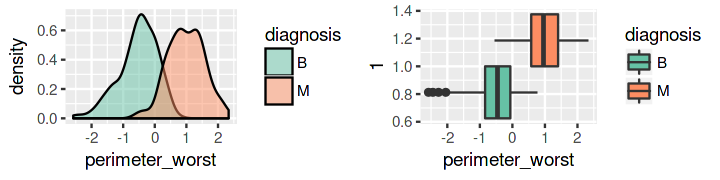

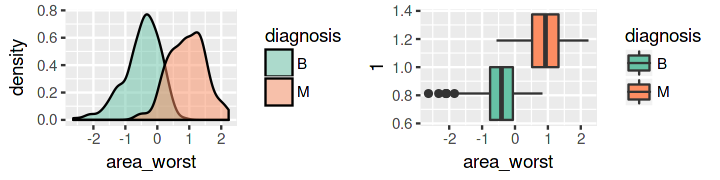

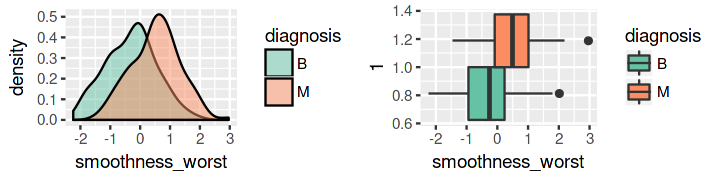

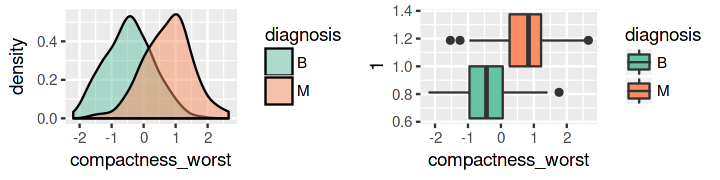

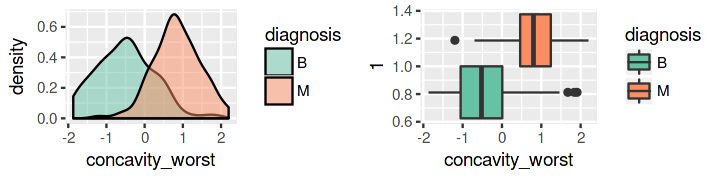

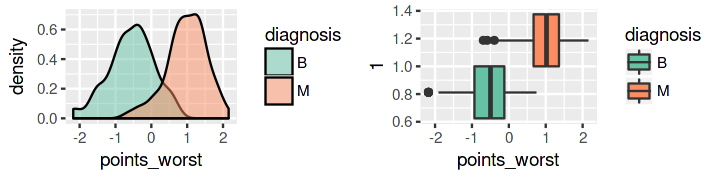

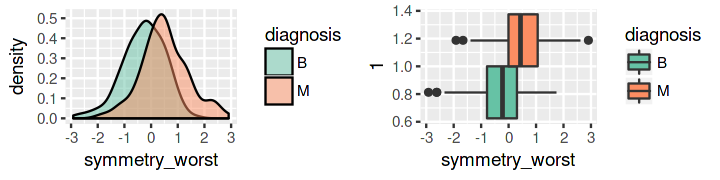

$radius_mean
NULL

$texture_mean
NULL

$perimeter_mean
NULL

$area_mean
NULL

$smoothness_mean
NULL

$compactness_mean
NULL

$concavity_mean
NULL

$points_mean
NULL

$symmetry_mean
NULL

$dimension_mean
NULL

$radius_se
NULL

$texture_se
NULL

$perimeter_se
NULL

$area_se
NULL

$smoothness_se
NULL

$compactness_se
NULL

$concavity_se
NULL

$points_se
NULL

$symmetry_se
NULL

$dimension_se
NULL

$radius_worst
NULL

$texture_worst
NULL

$perimeter_worst
NULL

$area_worst
NULL

$smoothness_worst
NULL

$compactness_worst
NULL

$concavity_worst
NULL

$points_worst
NULL

$symmetry_worst
NULL

$dimension_worst
NULL


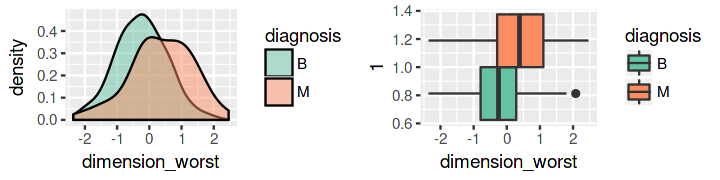

In [36]:
# Plot the distributions of all input features w.r.t. the target variable.
sapply(feature.names, function (x) {
    multiplot(ggplot(df4.train, aes_string(x = x, y = '..density..', fill = 'diagnosis')) +
                  geom_density(alpha = 0.5) +
                  scale_fill_brewer(palette = 'Set2'),
              ggplot(df4.train, aes_string(x = '1', y = x, fill = 'diagnosis')) +
                  geom_boxplot() +
                  coord_flip() +
                  scale_fill_brewer(palette = 'Set2'),
              cols = 2)
})

In [37]:
options(repr.plot.width = 8, repr.plot.height = 7)

Outliers can often be a source of problems for predictive models, since a model that fits outliers generalizes poorly. Therefore, removing outliers from the training data set can be a good idea to help models to achieve better results.

Only instances with the most extreme outliers were removed: those in which some feature value was below -3 or above 3.

### 3.4 Dimensionality reduction

In [38]:
# Compute the principal components (PC) of training data.
pc <- prcomp(df4.train[, feature.names], scale. = TRUE)
pc$rotation

PC1          PC2          PC3          PC4        
radius_mean        0.223055449  0.226903866 -0.024792118  0.03323855
texture_mean       0.105139563  0.047148845  0.294448850 -0.37872895
perimeter_mean     0.229182140  0.210014543 -0.032945326  0.02135191
area_mean          0.222476919  0.230301192 -0.020767361  0.03141620
smoothness_mean    0.123044360 -0.208342815 -0.078080834  0.32596991
compactness_mean   0.236890163 -0.160248258 -0.079137021 -0.01723368
concavity_mean     0.253928420 -0.069928862 -0.047828838 -0.06050090
points_mean        0.255490287  0.003803936 -0.039281794  0.06616017
symmetry_mean      0.111576086 -0.176766924  0.004064786  0.28979173
dimension_mean     0.019870435 -0.383301646 -0.076729705 -0.02462172
radius_se          0.187343857  0.065604995  0.285961629  0.25249745
texture_se         0.002327665 -0.089465814  0.490504936 -0.13012951
perimeter_se       0.203375023  0.024521313  0.274056342  0.16369822
area_se            0.217984315  0.124211069  0.209754109  0.18996249
smoothness_se     -0.004640972 -0.252485690  0.270958352  0.21221422
compactness_se     0.182462528 -0.225210716  0.071755463 -0.18167029
concavity_se       0.192591070 -0.171874982  0.039869264 -0.18109667
points_se          0.194757831 -0.122943297  0.133849712  0.02249403
symmetry_se        0.004210836 -0.191233655  0.295684148  0.23574455
dimension_se       0.104177390 -0.299142445  0.129943296 -0.12646874
radius_worst       0.229616441  0.218296923 -0.032527436  0.03809931
texture_worst      0.104043964  0.049724410  0.236019793 -0.40255199
perimeter_worst    0.237816110  0.195260207 -0.043300434  0.01285677
area_worst         0.228066481  0.222086965 -0.029817867  0.03362310
smoothness_worst   0.116501374 -0.182729588 -0.185323284  0.19993054
compactness_worst  0.220494854 -0.131980548 -0.189161875 -0.18610096
concavity_worst    0.235296304 -0.077018329 -0.161465514 -0.17364021
points_worst       0.252552741 -0.002470675 -0.131031835 -0.02226768
symmetry_worst     0.109722149 -0.110510104 -0.165273242  0.14648904
dimension_worst    0.120957983 -0.277372529 -0.212143415 -0.19196601
                  PC5          PC6          PC7          PC8         
radius_mean       -0.039902333  0.011288488 -0.001508899  0.020896774
texture_mean       0.355513232 -0.012122275 -0.052898178 -0.026059799
perimeter_mean    -0.045614770  0.013500982 -0.008152587  0.038242949
area_mean         -0.040104570  0.008003114  0.004547268  0.012375015
smoothness_mean    0.196181466 -0.312426823 -0.168755347  0.365247118
compactness_mean  -0.020582323 -0.012234001 -0.000729712  0.150927419
concavity_mean    -0.093483924  0.003037576 -0.151352514  0.035807934
points_mean       -0.057640139 -0.062601058 -0.184140638  0.164655570
symmetry_mean      0.243429037  0.383368937 -0.012948012  0.274655200
dimension_mean     0.035567569 -0.132049829  0.239585715  0.304944794
radius_se          0.016472008 -0.083265669  0.288468217 -0.048956275
texture_se         0.124573890 -0.088785009 -0.146292873  0.307825049
perimeter_se      -0.056356426 -0.036823623  0.282179395 -0.026079741
area_se            0.002107952 -0.065051750  0.224292343 -0.054890432
smoothness_se     -0.057294777 -0.287063219 -0.175609290 -0.558746444
compactness_se    -0.214722552  0.142456386  0.016704246 -0.120064510
concavity_se      -0.267867940  0.132134199 -0.237632222 -0.076338108
points_se         -0.296097274  0.019534535 -0.338085776  0.131521786
symmetry_se        0.014017672  0.445951566 -0.082504348 -0.131270697
dimension_se      -0.208729171 -0.011094276  0.391097751 -0.006760962
radius_worst       0.030619344 -0.021684399  0.073313601 -0.031434234
texture_worst      0.450900006 -0.064611534 -0.077956767 -0.013772636
perimeter_worst    0.011752354 -0.007468877  0.065456084 -0.026142082
area_worst         0.027839549 -0.025033422  0.074146190 -0.035652533
smoothness_worst   0.321120125 -0.381665058 -0.164404943 -0.295859402
compactness_worst  0.028501332  0.062694981  0.067551758 -0

In [39]:
# Project data onto the PC basis.
df5.train <- data.frame(pc$x)
df5.test <- data.frame(predict(pc, df4.test))

The PCA (Principal Component Analysis) technique was used here to transform the original data into a data set of uncorrelated components. Each PC is a linear combination of the original features. The first PCs are responsible for the majority of the data variance, so the remaining can be discarded without issues.

In [40]:
# Compute the variance explained by each PC.
pcvar <- pc$sdev ^ 2
pcvar.prop <- pcvar / sum(pcvar)
pcvar.cumsum <- data.frame(ncomponents = 1:ncol(df5.train), explvar = cumsum(pcvar.prop))

In [41]:
options(repr.plot.width = 6, repr.plot.height = 4)

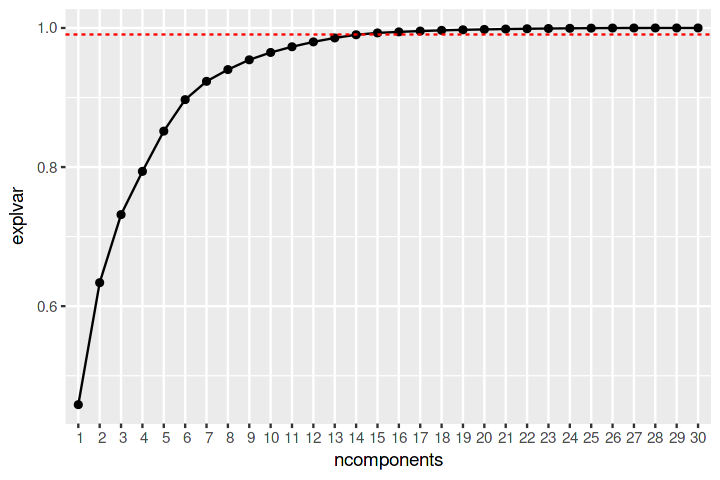

In [42]:
# Plot the cummulative explained variance proportions.
# The red dotted line shows the 99% level.
ggplot(pcvar.cumsum, aes(x = ncomponents, y = explvar)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 0.99, colour = 'red', linetype = 'dashed') +
    scale_x_discrete(limits = 1:ncol(df5.train))

In [43]:
# Get the least number of components needed to keep 99% of the original data variance.
ncomp <- pcvar.cumsum[pcvar.cumsum$explvar >= 0.99, 'ncomponents'][1]
ncomp

[1] 14

In [44]:
# Reduce the number of components.
df6.train <- df5.train[, 1:ncomp]
df6.train$diagnosis <- df4.train$diagnosis
df6.train$id <- df4.train$id

df6.test <- df5.test[, 1:ncomp]
df6.test$diagnosis <- df4.test$diagnosis
df6.test$id <- df4.test$id

In [45]:
# Get the component names.
pc.names <- colnames(df6.train[, 1:ncomp])
pc.names

[1] "PC1"  "PC2"  "PC3"  "PC4"  "PC5"  "PC6"  "PC7"  "PC8"  "PC9"  "PC10"
[11] "PC11" "PC12" "PC13" "PC14"

Only the components responsible for 99% of the original data variance were kept, thus reducing the dimensionality of our data sets from 30 to 14 features.

In [46]:
# Compute the p-values for the correlation tests.
cor.p <- cor.mtest(df6.train[, pc.names])[[1]]

In [47]:
options(repr.plot.width = 5, repr.plot.height = 4)

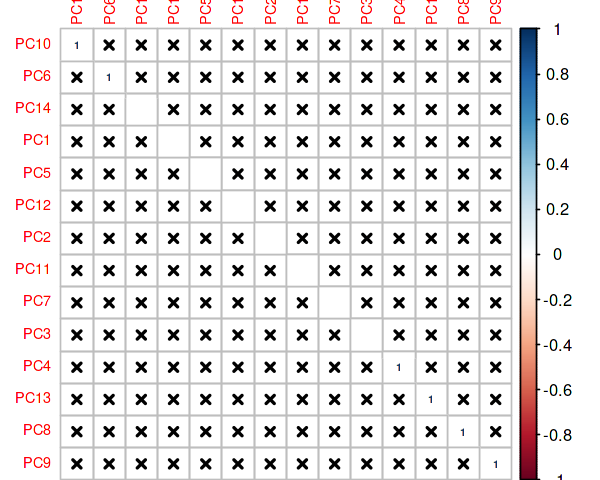

In [48]:
# Plot the pairwise feature correlation map.
corrplot.mixed(cor(df6.train[, pc.names]),
               lower = 'circle',
               upper = 'number',
               order = 'hclust',
               p.mat =  cor.p,
               sig.level = 0.01,
               tl.pos = 'lt',
               tl.cex = 0.7,
               number.cex = 0.5,
               pch.cex = 0.9)

In [49]:
options(repr.plot.width = 6, repr.plot.height = 1.5)

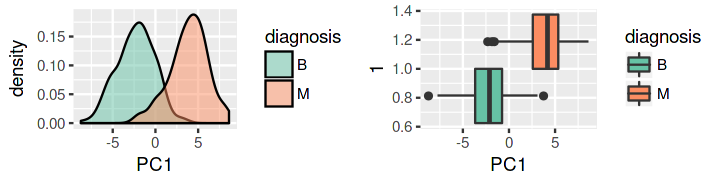

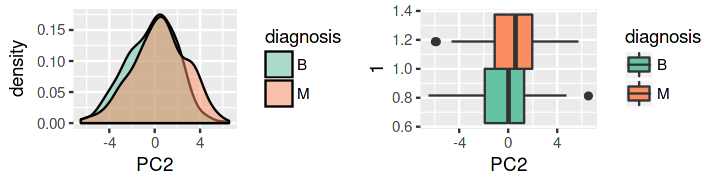

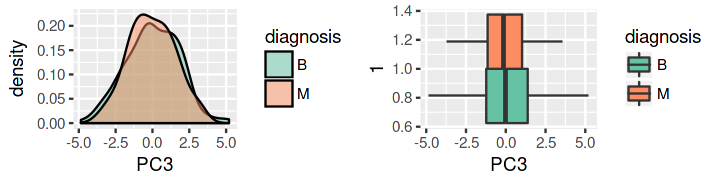

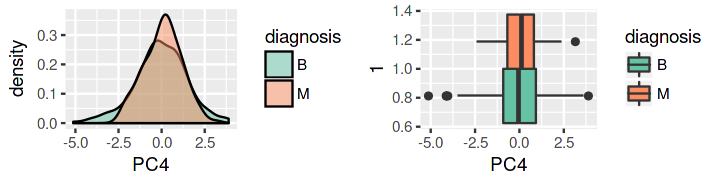

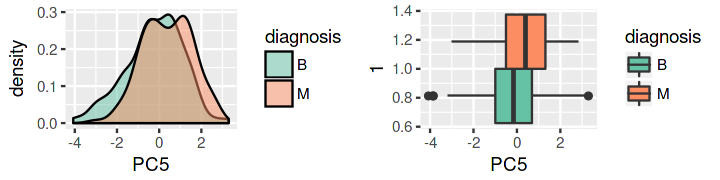

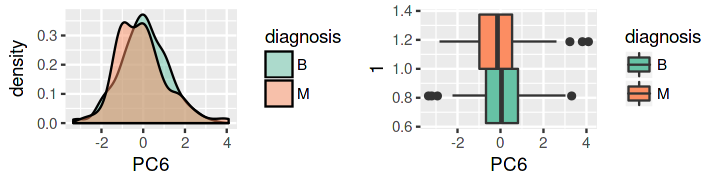

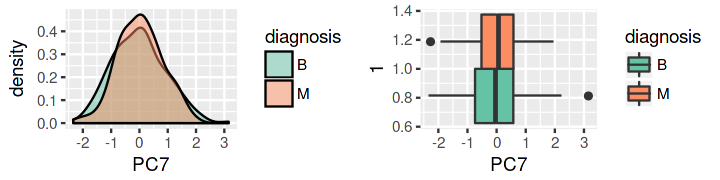

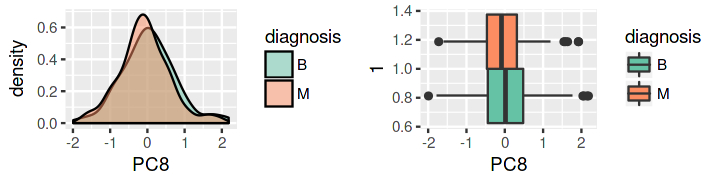

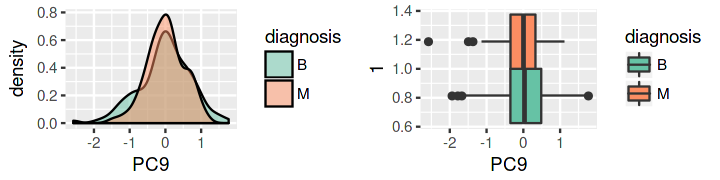

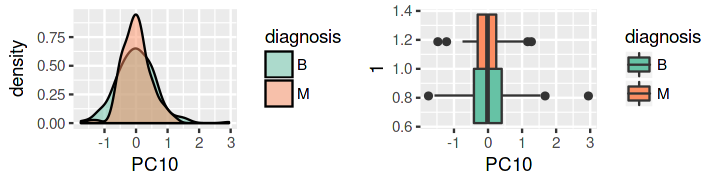

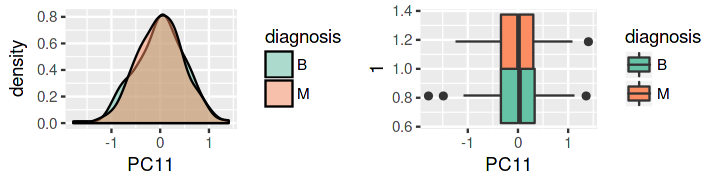

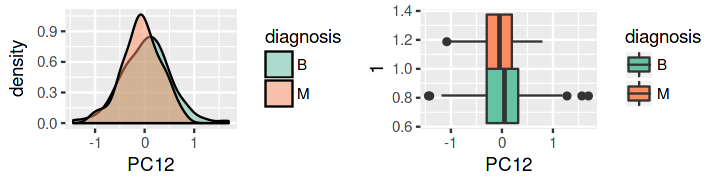

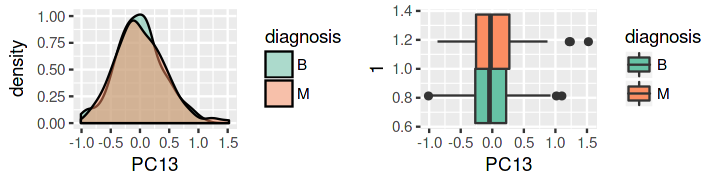

$PC1
NULL

$PC2
NULL

$PC3
NULL

$PC4
NULL

$PC5
NULL

$PC6
NULL

$PC7
NULL

$PC8
NULL

$PC9
NULL

$PC10
NULL

$PC11
NULL

$PC12
NULL

$PC13
NULL

$PC14
NULL


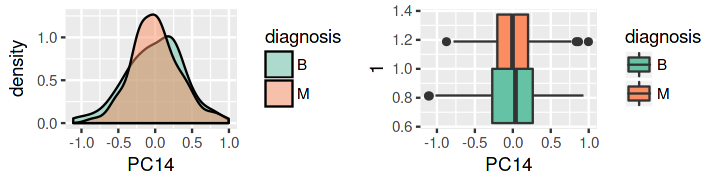

In [50]:
# Plot the distributions of all PCs w.r.t. the target variable.
sapply(pc.names, function (x) {
    multiplot(ggplot(df6.train, aes_string(x = x, y = '..density..', fill = 'diagnosis')) +
                  geom_density(alpha = 0.5) +
                  scale_fill_brewer(palette = 'Set2'),
              ggplot(df6.train, aes_string(x = '1', y = x, fill = 'diagnosis')) +
                  geom_boxplot() +
                  coord_flip() +
                  scale_fill_brewer(palette = 'Set2'),
              cols = 2)
})

The good news: now we have completely uncorrelated features.

The bad news: it looks that only the first component (PC1) is really useful to discriminate between class values. Is this really the case?

In [51]:
# Use recursive feature elimination (RFE) to find the best set of features.
rfe.ctrl <- rfeControl(functions = rfFuncs, method = 'repeatedcv', number = 10, repeats = 3)
rfe.results <- rfe(df6.train[, pc.names],
                   df6.train$diagnosis,
                   sizes = 1:ncomp,
                   rfeControl = rfe.ctrl)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [52]:
rfe.results


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.8725 0.7252    0.05833 0.12633         
         2   0.9279 0.8444    0.04144 0.08933         
         3   0.9612 0.9156    0.03477 0.07602        *
         4   0.9567 0.9060    0.03940 0.08508         
         5   0.9585 0.9101    0.03964 0.08585         
         6   0.9532 0.8991    0.03687 0.07912         
         7   0.9513 0.8945    0.04488 0.09768         
         8   0.9532 0.8985    0.04011 0.08640         
         9   0.9505 0.8929    0.04151 0.09016         
        10   0.9505 0.8922    0.04155 0.09078         
        11   0.9487 0.8887    0.03923 0.08533         
        12   0.9460 0.8825    0.04029 0.08814         
        13   0.9442 0.8784    0.04505 0.09846         
        14   0.9433 0.8763    0.04399 0.09597         

The top 3 variables (out of 3):

In [53]:
options(repr.plot.width = 5, repr.plot.height = 3)

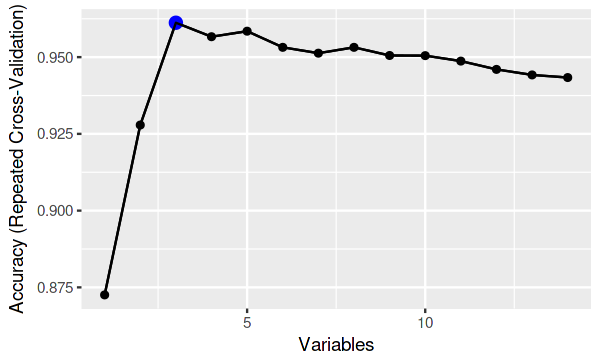

In [54]:
# Plot the RFE results.
ggplot(rfe.results, aes(x = Variables)) +
    geom_line()

In [55]:
head(df6.test)

PC1        PC2        PC3        PC4        PC5        PC6       
1  -2.3770945 -0.1752912 -1.3674929  2.7792646 -0.9237888  0.1098419
4  -1.7305899 -1.9693972  0.5754945  1.9700678 -2.3805947 -1.7422467
9  -2.8581162 -2.2998917  1.6909405  0.9312446  0.4805521  0.9980962
11  5.6309813  1.1471328 -0.2842367 -0.3789093 -0.1298331 -1.9425303
12 -2.1308601 -0.1889947 -0.7795007 -0.2545624  0.6488898  1.0849443
13  0.8147333 -0.4008084 -0.4819647 -1.3577662 -1.0310322 -0.4081445
   PC7         PC8         PC9       PC10       PC11        PC12      
1  -1.15405039 -0.05240851 0.1730098  0.5189028  0.25242261 -0.1314143
4  -1.36801396  0.66903178 0.7442892  0.2856980 -0.23015323  1.0429806
9   0.30434473  0.58940829 0.7706949  0.1211957  0.14743804  0.7692135
11  0.14518329  0.61857998 0.3584558  0.8213895 -0.16539374  0.3267951
12 -0.01430765  0.13782454 0.2338399  0.5635082 -0.01580193 -0.1940638
13 -0.31856973 -1.25338627 0.6994367 -0.4886816  0.39974772  0.3132179
   PC13       PC14        diagnosis id      
1  -0.1226966  0.12951460 B         87139402
4  -1.0057435  0.72838473 B           868871
9   0.4425714  0.15927839 B           862989
11  0.3276047 -0.23971371 M            91485
12  0.1312674 -0.31529844 B          8711003
13  0.1960113 -0.01530107 B          9113455

In [56]:
# Keep only the selected features.
df7.train <- df6.train[, c('diagnosis', predictors(rfe.results))]
df7.test <- df6.test[, c('diagnosis', predictors(rfe.results))]

Using RFE (Recursive Feature Elimination) with a Random Forest model, a smaller subset of components that maximize the classification accuracy could be found. It turned out that only 3 components are enough for good results.

Now the predictive models can finally be trained.

## 4 Model training

In [57]:
train.ctrl <- trainControl(method = 'cv',
                           number = 10,
                           classProbs = TRUE,
                           savePredictions = TRUE,
                           summaryFunction = twoClassSummary)

All training procedures will utilize 10-fold cross validation for the tuning and performance measurements.

### 4.1 Linear Discriminant Analysis (LDA)

In [58]:
# Train a predictive model using LDA.
ld <- train(diagnosis ~ .,
            method = 'lda',
            data = df7.train,
            trControl = train.ctrl,
            metric = 'ROC')
ld

Linear Discriminant Analysis 

371 samples
  3 predictors
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 334, 334, 333, 335, 333, 333, ... 
Resampling results:

  ROC       Sens       Spec     
  0.991595  0.9826087  0.9335165

 

LDA is a feature extraction technique that transforms data in order to produce new features that minimize the within-class variance and maximize the between-class variance. It is also a classification technique by itself.

In this case, LDA combined our PC features reducing them to a single value that is then used as threshold for the classification.

In [59]:
# Recompute LDA on training data.
ld2 <- lda(diagnosis ~ ., data = df7.train)
ld2

Call:
lda(diagnosis ~ ., data = df7.train)

Prior probabilities of groups:
        B         M 
0.6280323 0.3719677 

Group means:
        PC1        PC5        PC2
B -2.296452 -0.2293480 -0.2557667
M  3.877344  0.3872324  0.4318380

Coefficients of linear discriminants:
          LD1
PC1 0.4841293
PC5 0.3828243
PC2 0.1408972

In [60]:
# Project data onto the new basis.
ld2.pred.train <- predict(ld2, df7.train)
ld2.pred.test <- predict(ld2, df7.test)

In [61]:
# Get the projected data.
df8.train <- data.frame(ld2.pred.train$x)
df8.train$diagnosis <- df7.train$diagnosis

df8.test <- data.frame(ld2.pred.test$x)
df8.test$diagnosis <- df7.test$diagnosis

In [62]:
options(repr.plot.width = 8, repr.plot.height = 2.5)

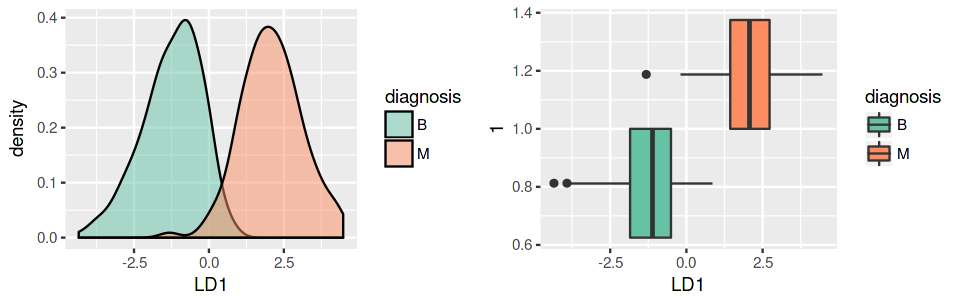

In [63]:
# Plot the distribution of the LD w.r.t. the target variable.
multiplot(ggplot(df8.train, aes_string(x = 'LD1', y = '..density..', fill = 'diagnosis')) +
              geom_density(alpha = 0.5) +
              scale_fill_brewer(palette = 'Set2'),
          ggplot(df8.train, aes_string(x = '1', y = 'LD1', fill = 'diagnosis')) +
              geom_boxplot() +
              coord_flip() +
              scale_fill_brewer(palette = 'Set2'),
          cols = 2)

With this new feature computed by LDA, the overlap region between the two classes is considerably small.

### 4.2 k-Nearest Neighbors (kNN)

In [64]:
# Train a predictive model using kNN.
knn.grid <- expand.grid(k = 1:21)
knn <- train(diagnosis ~ .,
             data = df7.train,
             method = 'knn',
             trControl = train.ctrl,
             metric = 'ROC',
             tuneGrid = knn.grid)
knn

k-Nearest Neighbors 

371 samples
  3 predictors
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 333, 333, 334, 334, 334, 334, ... 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec     
   1  0.9497770  0.9572464  0.9423077
   2  0.9760601  0.9574275  0.9417582
   3  0.9795738  0.9914855  0.9417582
   4  0.9802641  0.9956522  0.9280220
   5  0.9794638  0.9913043  0.9274725
   6  0.9790039  0.9956522  0.9351648
   7  0.9856989  0.9913043  0.9351648
   8  0.9850842  0.9869565  0.9274725
   9  0.9881963  0.9913043  0.9274725
  10  0.9881455  0.9913043  0.9203297
  11  0.9887492  0.9913043  0.9131868
  12  0.9884451  0.9913043  0.9131868
  13  0.9876463  0.9913043  0.9131868
  14  0.9878071  0.9871377  0.9065934
  15  0.9875030  0.9871377  0.8994505
  16  0.9871924  0.9871377  0.8994505
  17  0.9870486  0.9871377  0.9060440
  18  0.9875015  0.9871377  0.8989011
  19  0.9876503  0.9869565  0.8917582
  20

A grid search was used to find the best value for the `k` parameter (number of nearest neighbors) of the kNN algorithm. The best results in the validation sets were achieved using `k = 11`.

### 4.3 Random Forest

In [65]:
# Train a predictive model using Random Forest.
rf.grid <- expand.grid(mtry = 1:(ncol(df7.train) - 1))
rf <- train(diagnosis ~ .,
            data = df7.train,
            method = 'rf',
            trControl = train.ctrl,
            metric = 'ROC',
            tuneGrid = rf.grid)
rf

Random Forest 

371 samples
  3 predictors
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 334, 334, 334, 333, 335, 333, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
  1     0.9837952  0.9742754  0.9197802
  2     0.9791682  0.9701087  0.8983516
  3     0.9808668  0.9614130  0.8840659

ROC was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 1. 

A grid search was used to find the best value for the `mtry` parameter (number of random features considered by each decision tree) of the Random Forest algorithm. The best results in the validation sets were achieved using `mtry = 1` (a forest of single-noded trees).

### 4.3 Support Vector Machines (SVM)

In [66]:
# Train a predictive model using SVM (with radial kernel).
svm.grid <- expand.grid(C = 10^(-3:6), sigma = 10^(-5:0))
svm <- train(diagnosis ~ .,
             data = df7.train,
             method = 'svmRadial',
             trControl = train.ctrl,
             metric = 'ROC',
             tuneGrid = svm.grid)
svm

Loading required package: kernlab

Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha



maximum number of iterations reached 0.0001557115 0.0001557113maximum number of iterations reached 0.001563966 0.001563918maximum number of iterations reached 0.01277555 0.01263607maximum number of iterations reached 0.004805054 0.004819746maximum number of iterations reached 0.001569085 0.001569034maximum number of iterations reached 0.01282423 0.01268526maximum number of iterations reached 0.004695938 0.004685542maximum number of iterations reached 0.01274824 0.01261328maximum number of iterations reached 0.004480912 0.004459722maximum number of iterations reached 0.005310945 0.005311901maximum number of iterations reached 0.0001568606 0.0001568605maximum number of iterations reached 0.001563634 0.001563593maximum number of iterations reached 0.01264779 0.01250939maximum number of iterations reached 0.005155887 0.005146259maximum number of iterations reached 0.001559886 0.001559843maximum number of iterations reached 0.01274666 0.01260343maximum number of iterations reached 0.0051730

Support Vector Machines with Radial Basis Function Kernel 

371 samples
  3 predictors
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 333, 334, 333, 334, 334, 334, ... 
Resampling results across tuning parameters:

  C      sigma  ROC        Sens       Spec     
  1e-03  1e-05  0.9901398  1.0000000  0.0000000
  1e-03  1e-04  0.9901398  1.0000000  0.0000000
  1e-03  1e-03  0.9904503  1.0000000  0.5445055
  1e-03  1e-02  0.9907479  0.8842391  0.9857143
  1e-03  1e-01  0.9898033  0.8927536  0.9785714
  1e-03  1e+00  0.9845626  0.9233696  0.9785714
  1e-02  1e-05  0.9901398  1.0000000  0.0000000
  1e-02  1e-04  0.9901398  1.0000000  0.5587912
  1e-02  1e-03  0.9907479  0.9014493  0.9857143
  1e-02  1e-02  0.9907479  0.8626812  0.9857143
  1e-02  1e-01  0.9901139  0.8969203  0.9857143
  1e-02  1e+00  0.9836310  0.9190217  0.9785714
  1e-01  1e-05  0.9901398  1.0000000  0.5802198
  1e-01  1e-04  0.9907479  0.8971014  0.9857143
  1e-0

A grid search was used to find the best value for the `C` and `sigma` parameters (regularization constant and inverse kernel spread, respectively) of the SVM algorithm. A radial (Gaussian) kernel was employed to fit the data. The best results in the validation sets were achieved using `C = 100` and `sigma = 0.001` (not much regularization and a somewhat high kernel spread).

In [67]:
# Find indices of the best predictions in the parameter grid.
knn.best.idx <- knn$pred$k == knn$bestTune$k
rf.best.idx <- rf$pred$mtry == rf$bestTune$mtry
svm.best.idx <- (svm$pred$C == svm$bestTune$C) & (svm$pred$sigma == svm$bestTune$sigma)

In [68]:
options(repr.plot.width = 4, repr.plot.height = 3)


Call:
plot.roc.default(x = ld$pred$obs, predictor = ld$pred$M, print.auc = TRUE)

Data: ld$pred$M in 233 controls (ld$pred$obs B) < 138 cases (ld$pred$obs M).
Area under the curve: 0.9926

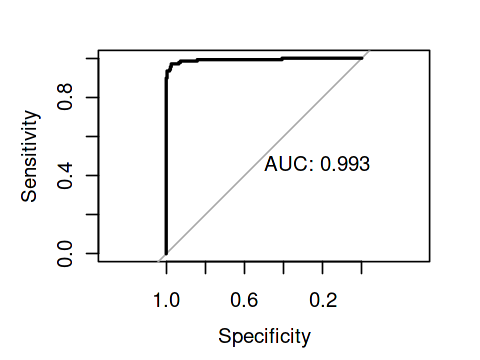


Call:
plot.roc.default(x = knn$pred$obs[knn.best.idx], predictor = knn$pred$M[knn.best.idx],     print.auc = TRUE)

Data: knn$pred$M[knn.best.idx] in 233 controls (knn$pred$obs[knn.best.idx] B) < 138 cases (knn$pred$obs[knn.best.idx] M).
Area under the curve: 0.9876

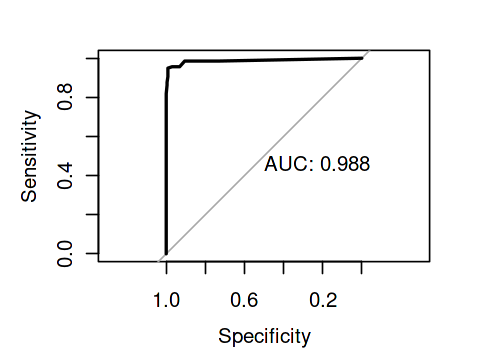


Call:
plot.roc.default(x = rf$pred$obs[rf.best.idx], predictor = rf$pred$M[rf.best.idx],     print.auc = TRUE)

Data: rf$pred$M[rf.best.idx] in 233 controls (rf$pred$obs[rf.best.idx] B) < 138 cases (rf$pred$obs[rf.best.idx] M).
Area under the curve: 0.9838

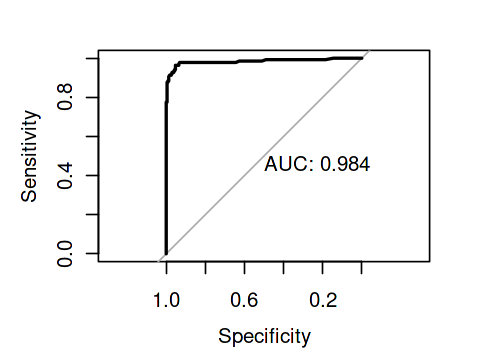


Call:
plot.roc.default(x = svm$pred$obs[svm.best.idx], predictor = svm$pred$M[svm.best.idx],     print.auc = TRUE)

Data: svm$pred$M[svm.best.idx] in 233 controls (svm$pred$obs[svm.best.idx] B) < 138 cases (svm$pred$obs[svm.best.idx] M).
Area under the curve: 0.9928

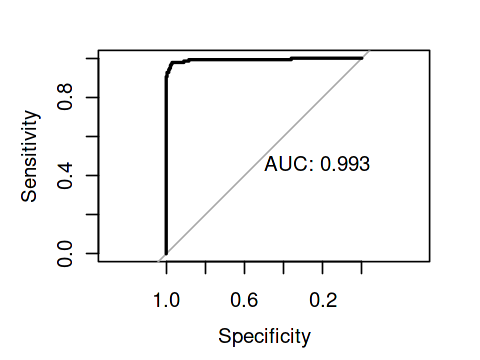

In [69]:
# Plot the ROC curves and the area under them (AUC).
plot.roc(ld$pred$obs, ld$pred$M, print.auc = TRUE)
plot.roc(knn$pred$obs[knn.best.idx], knn$pred$M[knn.best.idx], print.auc = TRUE)
plot.roc(rf$pred$obs[rf.best.idx], rf$pred$M[rf.best.idx], print.auc = TRUE)
plot.roc(svm$pred$obs[svm.best.idx], svm$pred$M[svm.best.idx], print.auc = TRUE)

The ROC curves for the four predictive models are presented above. The very high AUC (area under curve) values show that all models had excellent performance in the validation sets. Now only the final tests remain. 

## 5 Model evaluation

In [70]:
ld.pred <- predict(ld, df7.test)
confusionMatrix(ld.pred, df7.test$diagnosis, positive = 'M')

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 106   5
         M   1  58
                                          
               Accuracy : 0.9647          
                 95% CI : (0.9248, 0.9869)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9233          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.9206          
            Specificity : 0.9907          
         Pos Pred Value : 0.9831          
         Neg Pred Value : 0.9550          
             Prevalence : 0.3706          
         Detection Rate : 0.3412          
   Detection Prevalence : 0.3471          
      Balanced Accuracy : 0.9556          
                                          
       'Positive' Class : M               
                                          

In [71]:
knn.pred <- predict(knn, df7.test)
confusionMatrix(knn.pred, df7.test$diagnosis, positive = 'M')

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 106   5
         M   1  58
                                          
               Accuracy : 0.9647          
                 95% CI : (0.9248, 0.9869)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9233          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.9206          
            Specificity : 0.9907          
         Pos Pred Value : 0.9831          
         Neg Pred Value : 0.9550          
             Prevalence : 0.3706          
         Detection Rate : 0.3412          
   Detection Prevalence : 0.3471          
      Balanced Accuracy : 0.9556          
                                          
       'Positive' Class : M               
                                          

In [72]:
rf.pred <- predict(rf, df7.test)
confusionMatrix(rf.pred, df7.test$diagnosis, positive = 'M')

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 103   4
         M   4  59
                                          
               Accuracy : 0.9529          
                 95% CI : (0.9094, 0.9795)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8991          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9365          
            Specificity : 0.9626          
         Pos Pred Value : 0.9365          
         Neg Pred Value : 0.9626          
             Prevalence : 0.3706          
         Detection Rate : 0.3471          
   Detection Prevalence : 0.3706          
      Balanced Accuracy : 0.9496          
                                          
       'Positive' Class : M               
                                          

In [73]:
svm.pred <- predict(svm, df7.test)
confusionMatrix(svm.pred, df7.test$diagnosis, positive = 'M')

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 105   1
         M   2  62
                                          
               Accuracy : 0.9824          
                 95% CI : (0.9493, 0.9963)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9623          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9841          
            Specificity : 0.9813          
         Pos Pred Value : 0.9688          
         Neg Pred Value : 0.9906          
             Prevalence : 0.3706          
         Detection Rate : 0.3647          
   Detection Prevalence : 0.3765          
      Balanced Accuracy : 0.9827          
                                          
       'Positive' Class : M               
                                          

Finally, the models were evaluated in the test set. The results are summarized by several metrics, as seen above. In general, we can say that all models performed great, since very few misclassifications have happened. Accuracy, sensitivity (true positive rate) and specificity (true negative rate) are always above 90%.

We should notice that the misclassifications consist mostly of false negatives (malignant tumors that were classified as benign). Perhaps it would be better to adjust the models so that they avoid false negative at the cost of producing more false positives. Or perhaps we could collect more data from patients with malignant tumors, allowing models to get even better at learning what a malignant tumor is like.

In [74]:
options(repr.plot.width = 8, repr.plot.height = 6)

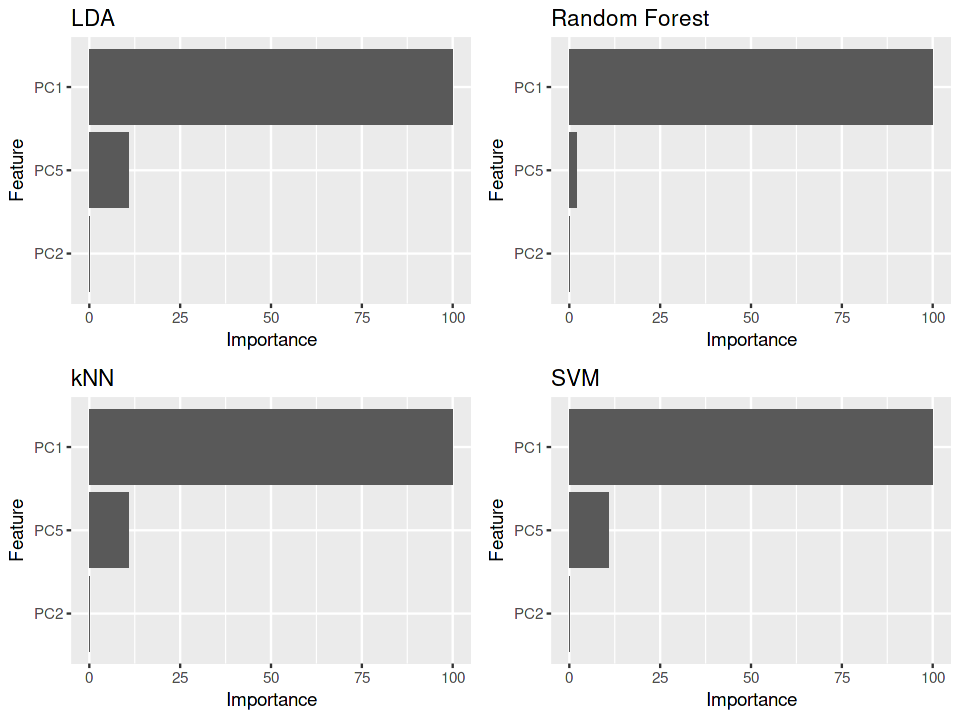

In [75]:
# Plot the feature importances for all models.
multiplot(ggplot(varImp(ld)) + ggtitle('LDA'),
          ggplot(varImp(knn)) + ggtitle('kNN'),
          ggplot(varImp(rf)) + ggtitle('Random Forest'),
          ggplot(varImp(svm)) + ggtitle('SVM'),
          cols = 2)

Just to finish, the feature importance scores are shown above. Predictably, the first principal component was by far the most important feature for all models.